# Feature selection Analysis
___

#### Introduction
* [1.1 K-Fold Cross Validation ](#1.1)
* 1.2 Early Stopping
* 1.3 Grid Search by Person Split
* 1.4 Grid search by Time Series Split.

#### Results
* 2.1. Person Split, basic features
* 2.2. Person Split, All Features
* 2.3. Time Series Split, basic features
* 2.4. Time Series Split, All Features

## Introduction
___

Having chosen the best hyper parameters from our selection our next steps will be to analyse feature importances
* Can we remove features that do not add value to our model predictability and further improve accuracy?

In [1]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [107]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
import joblib
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import train_test_split

import shap
shap.initjs()
import timeit

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

from catboost.utils import select_threshold
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, GroupShuffleSplit
import seaborn as sns

%load_ext autoreload
%autoreload 2
%aimport src.models.train_model
%aimport src.data.make_dataset

from src.data import make_dataset
from src.data.make_dataset import save_file
from src.models import train_model
from src.models.train_model import grid_search_results, generate_folds, show_model_results, label_creater, exploratory_training

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def importances(model, train_pool, test_pool):
    '''
    Comparison of sorted feature imporances based on:
    1. PredictionValuesChange
    2. LossFunctionChange
    3. ShapValues
        
    Parameters
    -----------
    model: Catboost model
               
    Returns
    -------
    DataFrame
    '''
    importance = pd.DataFrame(np.array(model.get_feature_importance(prettified=True)))
    loss_function_change = pd.DataFrame(
                                        np.array(model.get_feature_importance(
                                        train_pool,
                                        'LossFunctionChange',
                                        prettified=True)))
    loss_function_change_test = pd.DataFrame(
                                            np.array(model.get_feature_importance(
                                            test_pool,
                                            'LossFunctionChange',
                                            prettified=True)))
    
    df = pd.concat([importance, loss_function_change, loss_function_change_test], axis=1)
    df.columns = ['feature0', 'importance0', 'feature1', 'importance1', 'feature2', 'importance2']
    features = [x for x in df.columns if 'feature' in x]
    
    # separate by features and importances
    feature_list =[]
    for i, j in enumerate(features):
        feature_list.append(df[[j, 'importance'+str(i)]].set_index(j))
    
    # join by features as indedx
    features_joined = feature_list[0]
    for i in range(len(feature_list))[1:]:
        features_joined = features_joined.join(feature_list[i])
        
    return features_joined

In [4]:
def gridsearch_early_stopping_importance(cv, X, y, folds, grid, cat_features=[], save=None):
    '''
    Perform grid search with early stopping across folds specified by index 
    
    Parameters
    -----------
    cv: cross validation
    X: DataFrame or Numpy array
    y: DataFrame or Numpy array
    fold: list of fold indexes
    grid: parameter grid
    save:   string, excluding file extension (default=None)
            saves results_df for each fold to folder '../../data/interim'
    '''
        
    # generate data folds
    train_X, train_y, test_X, test_y = generate_folds(cv, X, y)
      
    
    importance_folds = [0 for fold in folds]
    
    # iterate through specified folds
    for fold in folds:
        # assign train and test pools
        test_pool = Pool(data=test_X[fold], label=test_y[fold], cat_features=cat_features)
        train_pool = Pool(data=train_X[fold], label=train_y[fold], cat_features=cat_features)

        # creating results_df dataframe
        results_df = pd.DataFrame(columns=['params' + str(fold), 'logloss'+ str(fold), 'Accuracy'+ str(fold), 'iteration'+ str(fold)])

        best_score = 99999

        # iterate through parameter grid
        for params in ParameterGrid(grid):

            # create catboost classifer with parameter params
            model = CatBoostClassifier(cat_features=cat_features,
                                        early_stopping_rounds=50,
                                        task_type='GPU',
                                        custom_loss=['Accuracy'],
                                        iterations=7000,
                                        **params)
            # fit model
            model.fit(train_pool, eval_set=test_pool, verbose=400)
            importance_folds[fold] = importances(model, train_pool, test_pool)

    return(importance_folds)

In [5]:
t = ['t_1', 't_3', 't_7', 't_14', 't_21', 't_30', 't_1c', 't_3c', 
         't_7c', 't_14c', 't_21c', 't_30c']
hist = ['hist_reward_completed',
        'hist_reward_possible', 'hist_difficulty_completed', 
        'hist_difficulty_possible', 'hist_previous_completed',
        'hist_previous_offers', 'hist_viewed_and_completed',
        'hist_complete_not_viewed', 'hist_failed_complete', 
        'hist_viewed', 'hist_received_spend', 'hist_viewed_spend']
day = ['day', 'weekday', 'month', 'year']
last = ['last_amount', 'last_transaction_days']

In [6]:
def remove_features(df, feature_list):
    '''
    Removes specified groups of features from DataFrame
    '''
    remove_list = []
    for features in feature_list:
        for feature in features:
            remove_list.append(feature)
    
    df_removed = df.drop(remove_list, axis=1)         
    
    return df_removed

In [7]:
def feature_transformer(remove=None, test=False, file='../../data/interim/transcript_final.joblib'):
    '''
    Takes final features in .joblib format and transforms DataFrame to be ready for modelling.
    Parameters
    -----------
    remove: list of feature groups or columns to remove
    test: integer - limit data to first n rows, used to reduce dimensions for testing
    file: .joblib file path of base data, defaults to '../../data/interim/transcript_final.joblib'    
    Returns
    -----------
    DataFrame
    '''   
    df = joblib.load(file)
    df = src.models.train_model.drop_completion_features(df)
    df.sort_values('time_days', inplace=True)
    
    if test:
        df = df[0:test]
    if remove:
        df = remove_features(df, feature_list=remove)
    
    return df  

In [8]:
def set_target(df, target='completed'):
    '''
    Sets the target variable to predict to Y and removes target variable from X.
    Parameters
    -----------
    target: string, columns name of target variable to predict.
    Returns
    -----------
    X and y DataFrames ready for training
    '''
     
    X = df.drop(target, axis=1)
    y = df[target]
    return X, y    

In [9]:
def train_test_splitting_method(X, y, method):
    '''
    Split into train and test by method.
    Parameters
    -----------
    X, y: DataFrame or arrays
    method: string, 
            'person' to split by groups of customers
            'time', to split by time_days using TimesSeriesSplit
    Returns
    -----------
    Split Dataframes: X_train , y_train, X_test, y_test    
    '''  
       
    if method == 'person':
        cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
        X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
        X_train=X_train[0]
        y_train=y_train[0]
        X_test=X_test[0]
        y_test=y_test[0]
    
    if method == 'time':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
        
    return X_train, X_test, y_train, y_test   

In [10]:
def cv_method(X_train, y_train, method):
    '''
    Split into train and test by method.
    Parameters
    -----------
    X, y: DataFrame or arrays
    method: string, 
            'person' to split by groups of customers
            'time', to split by time_days using TimesSeriesSplit
    Returns
    -----------
    Split Dataframes: X_train , y_train, X_test, y_test    
    '''  
       
    if method == 'person':
        cv = GroupKFold(n_splits=5).split(X_train, y_train, groups=X_train.person)
    if method == 'time':
        cv = TimeSeriesSplit(n_splits=5).split(X_train, y_train)

    return cv

In [56]:
def best_param_grid(grid_results_file, metric='logloss_mean', folds=5):
    '''
    Takes grid search results file(s) and returns optimal parameters
    Parameters
    -----------
    grid_search_file: file name excluding extention and fold suffix
    folds: number of folds (or files) 
    metric: which metric to choose best parameters from, default ('logloss_mean')
    Returns
    -----------
    grid: dictionary of lists of parameters  
    '''  
    
    results_person, best_scores = grid_search_results(grid_results_file, 5, display_results=False)
    
    grid = best_scores[best_scores.Metric == metric + '_mean'].Params.values[0]
    
    for i in grid:
        grid[i] = [grid[i]]
        
    print('Training with ' + str(grid))
    
    return grid

## Cross validation test importances comparison
* Using the best features as previously aquired via gridsearch
* Compare feature importances for each fold

In [12]:
complete = {'completed_not_viewed': 1, 
        'completed_before_viewed': 1, 
        'complete_anyway': 1,
        'completed_responsive': 1,
        'incomplete_responsive': 0,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'failed':0, 'completed':1}

In [41]:
grid

{'depth': [7], 'l2_leaf_reg': [1], 'learning_rate': [0.01]}

In [91]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = label_creater(df, label_grid=complete)

In [58]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = label_creater(df, label_grid=complete)
cat_features = [0,4,5,92,93,94,95,96,97]
grid = best_param_grid('multiclass_gridsearch_inc10', metric='Accuracy', folds=5)

df.sort_values('time_days', inplace=True)

X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
cv = TimeSeriesSplit(n_splits=5).split(X_train, y_train)

weights = [df.label.value_counts().sum() / df.label.value_counts()[i] for i in range(0, df.label.nunique())]

importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)

Training with {'depth': [7], 'l2_leaf_reg': [1], 'learning_rate': [0.01]}
positive classification % per fold and length
train[0] 0.3988 (10171,)
test[0]  0.4224 (10170,)
train[1] 0.4106 (20341,)
test[1]  0.4496 (10170,)
train[2] 0.4236 (30511,)
test[2]  0.4618 (10170,)
train[3] 0.4331 (40681,)
test[3]  0.4679 (10170,)
train[4] 0.4401 (50851,)
test[4]  0.4674 (10170,)
0:	learn: 0.6829140	test: 0.6831325	best: 0.6831325 (0)	total: 86.2ms	remaining: 10m 3s
400:	learn: 0.4177062	test: 0.4260632	best: 0.4260632 (400)	total: 36.3s	remaining: 9m 57s
800:	learn: 0.4100662	test: 0.4239917	best: 0.4239917 (800)	total: 2m 34s	remaining: 19m 57s
1200:	learn: 0.4040011	test: 0.4232440	best: 0.4232440 (1200)	total: 4m 18s	remaining: 20m 46s
1600:	learn: 0.3988598	test: 0.4229329	best: 0.4229285 (1588)	total: 5m 42s	remaining: 19m 15s
2000:	learn: 0.3963069	test: 0.4227091	best: 0.4227073 (1995)	total: 6m 43s	remaining: 16m 48s
bestTest = 0.4226940354
bestIteration = 2132
Shrink model to first 2133 i

In [64]:
joblib.dump(importance_results, '../../models/importances_multi.joblib', compress=True)

['../../models/importances_multi.joblib']

In [65]:
importances_multi = joblib.load('../../models/importances_multi.joblib')

In [92]:
df

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer,label
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,1
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1.0,2.0,2.0,2.0,2.0,2.0,17.78,1.00,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,0.00,NaN,NaN,NaN,NaN,,,,,,,0.758621,5.50,1.75,19.89,17.78,3.616364,10.160000,0
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0.0,1.0,2.0,5.0,5.0,5.0,23.93,1.25,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,87.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,NaN,NaN,j,,,,,,0.318841,5.50,11.75,19.89,91.10,3.616364,7.753191,1
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,5.25,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,0.00,NaN,j,,b,,,,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739,1
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,9fcbff4f8d7241faa4ab8a9d19c8a812,47.0,94000.0,-286,1,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,21.0,3,4,11,2017,0.00,0.00,0.00,0.00,0.00,0.00,0

0:	learn: 1.0807159	test: 1.0814417	best: 1.0814417 (0)	total: 51ms	remaining: 5m 56s
500:	learn: 0.6579460	test: 0.6988046	best: 0.6988046 (500)	total: 13s	remaining: 2m 48s
1000:	learn: 0.6227612	test: 0.6850128	best: 0.6850128 (1000)	total: 25.3s	remaining: 2m 31s
1500:	learn: 0.5959485	test: 0.6796167	best: 0.6796167 (1500)	total: 37.6s	remaining: 2m 17s
bestTest = 0.6774516568
bestIteration = 1797
Shrink model to first 1798 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.7063450445726271'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.94      0.76      0.84      8809
 complete after       0.59      0.60      0.60      3872
complete before       0.42      0.70      0.53      2575

       accuracy                           0.71     15256
      macro avg       0.65      0.68      0.65     15256
   weighted avg       0.76      0.71      0.72     15256



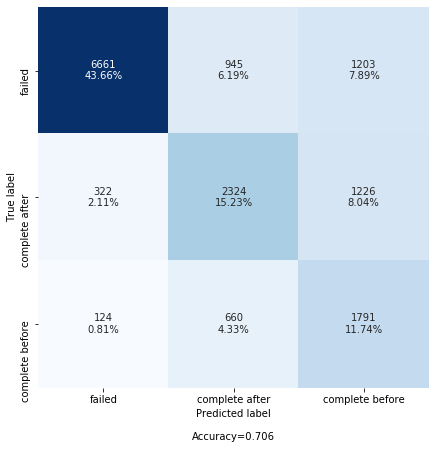

In [105]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, drop_features=to_remove, labels_compact=labelling)

0:	learn: 1.0923861	test: 1.0926312	best: 1.0926312 (0)	total: 32.9ms	remaining: 3m 50s
500:	learn: 0.6898957	test: 0.7216065	best: 0.7216065 (500)	total: 14.1s	remaining: 3m 3s
1000:	learn: 0.6568513	test: 0.7013062	best: 0.7013049 (999)	total: 27.8s	remaining: 2m 46s
1500:	learn: 0.6343358	test: 0.6916781	best: 0.6916757 (1499)	total: 41.5s	remaining: 2m 32s
2000:	learn: 0.6157859	test: 0.6858880	best: 0.6858880 (2000)	total: 58.3s	remaining: 2m 25s
2500:	learn: 0.5988210	test: 0.6815936	best: 0.6815936 (2500)	total: 1m 34s	remaining: 2m 50s
3000:	learn: 0.5834524	test: 0.6783635	best: 0.6783603 (2999)	total: 2m 29s	remaining: 3m 19s
3500:	learn: 0.5690859	test: 0.6760533	best: 0.6760533 (3500)	total: 3m 25s	remaining: 3m 24s
4000:	learn: 0.5553579	test: 0.6745877	best: 0.6745786 (3999)	total: 4m 20s	remaining: 3m 15s
bestTest = 0.6744105819
bestIteration = 4067
Shrink model to first 4068 iterations.



'Learning Rate set to: 0.009999999776'

'Accuracy Score: 0.7111300471945464'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.94      0.76      0.84      8809
 complete after       0.60      0.62      0.61      3872
complete before       0.43      0.68      0.53      2575

       accuracy                           0.71     15256
      macro avg       0.65      0.69      0.66     15256
   weighted avg       0.76      0.71      0.73     15256



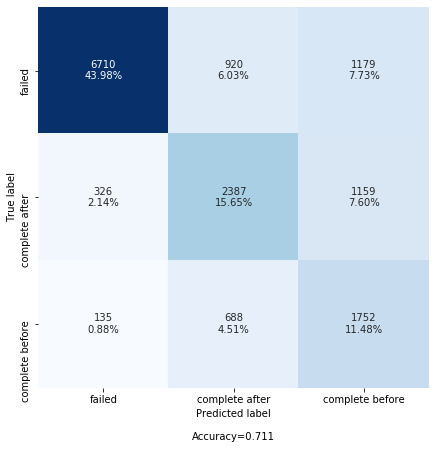

In [106]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, drop_features=to_remove, labels_compact=labelling, **{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.01})

In [ ]:
{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.01}

[0, 4, 5, 68, 69, 70]

,person,age,income,signed_up,gender,id,rewarded,reward,mobile,social,day,weekday,month,year,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_received_spend,hist_viewed_spend,a,c,d,e,f,g,h,i,received_0,received_1,received_3,received_4,received_5,received_7,received_9,viewed_0,viewed_1,viewed_3,viewed_4,viewed_5,viewed_8,count_0,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_30,offer_21,offer_24,offer_30,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,1.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,,,,0.00,0.00,NaN,NaN
16954,6b953f2664034c1cbdfbfdc6c81a7707,38.0,48000.0,-129,0,7,0.0,5.0,1.0,1.0,19,0,3,2018,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,,,,0.00,0.00,NaN,NaN
46985,0f6b76564fbb446c977f5330b3d8567c,40.0,38000.0,-1527,1,6,0.0,5.0,1.0,0.0,21,2,5,2014,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,,,,0.00,0.00,NaN,NaN
16949,511d8232e384437b99268226c8a5bb95,NaN,NaN,-814,0,2,0.0,10.0,1.0,1.0,3,1,5,2016,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,,,,0.00,0.00,NaN,NaN
46990,9bc4b2ca147b42d08a4c2c55a16c2604,84.0,31000.0,-481,0,8,0.0,0.0,1.0,0.0,1,5,4,2017,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,,,,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44950,aef581890b724d55bb806394eb7e76e7,NaN,NaN,-429,0,7,0.0,5.0,1.0,1.0,16,4,6,2017,1.14,1.14,1.14,1.14,1.14,1.0,1.0,1.0,1.0,1.0,1.0,1.14,1.00,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.00,3.26,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.0,h,,,1.14,0.00,0.506667,0.000000
44947,084c6cf4cd3a46a288e55ab2213e644c,52.0,34000.0,-304,1,7,0.0,5.0,1.0,1.0,19,3,10,2017,0.00,10.75,29.47,43.32,56.72,0.0,0.0,2.0,4.0,6.0,8.0,5.65,4.75,10.0,25.0,65.0,2.0,1.0,1.0,3.0,42.80,32.71,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,16.90,0.0,c,,,8.56,48.16,2.853333,2.266353
44941,6bb9186fb03e4d99a4c7f10ce849c65b,33.0,37000.0,-112,1,8,0.0,0.0,1.0,0.0,29,6,4,2018,0.00,0.00,15.41,15.91,15.91,0.0,0.0,0.0,2.0,3.0,3.0,4.97,8.75,2.0,10.0,42.0,1.0,1.0,0.0,4.0,20.38,0.00,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,20.38,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.50,0.0,h,,,0.00,15.91,0.000000,1.116491
44929,0f6d41cb9bd144e3b091286856d12f5c,NaN,NaN,-90,0,3,0.0,2.0,1.0,1.0,21,0,5,2018,2.41,5.69,5.69,11.65,13.66,1.0,1.0,2.0,2.0,3.0,4.0,2.41,1.00,5.0,5.0,20.0,1.0,1.0,0.0,2.0,5.29,5.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,N

0:	learn: 1.0923861	test: 1.0926313	best: 1.0926313 (0)	total: 99.1ms	remaining: 11m 33s
500:	learn: 0.6898369	test: 0.7214205	best: 0.7214205 (500)	total: 19.5s	remaining: 4m 13s
1000:	learn: 0.6568548	test: 0.7012430	best: 0.7012414 (999)	total: 36s	remaining: 3m 35s
1500:	learn: 0.6342260	test: 0.6912996	best: 0.6912996 (1500)	total: 52s	remaining: 3m 10s
2000:	learn: 0.6156150	test: 0.6855206	best: 0.6855206 (2000)	total: 1m 7s	remaining: 2m 49s
2500:	learn: 0.5988491	test: 0.6812447	best: 0.6812447 (2500)	total: 1m 26s	remaining: 2m 34s
3000:	learn: 0.5835646	test: 0.6783873	best: 0.6783835 (2999)	total: 2m 19s	remaining: 3m 6s
3500:	learn: 0.5692703	test: 0.6760791	best: 0.6760791 (3500)	total: 3m 15s	remaining: 3m 15s
4000:	learn: 0.5555425	test: 0.6747010	best: 0.6746913 (3998)	total: 4m 13s	remaining: 3m 9s
bestTest = 0.6745016032
bestIteration = 4073
Shrink model to first 4074 iterations.



'Learning Rate set to: 0.009999999776'

'Accuracy Score: 0.7121132669113791'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.94      0.76      0.84      8809
 complete after       0.60      0.62      0.61      3872
complete before       0.43      0.68      0.53      2575

       accuracy                           0.71     15256
      macro avg       0.65      0.69      0.66     15256
   weighted avg       0.76      0.71      0.73     15256



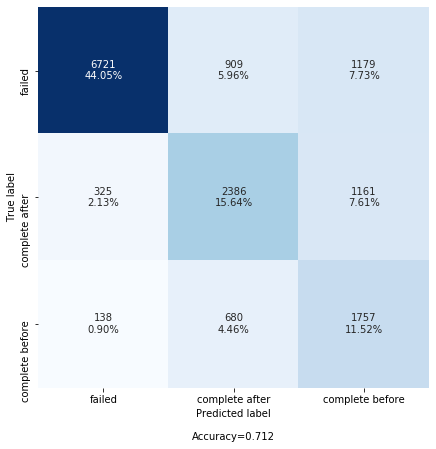

In [108]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, drop_features=to_remove, labels_compact=labelling, **{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.01})

[0, 4, 5, 86, 87, 88]

,person,age,income,signed_up,gender,id,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_4,count_5,count_6,count_7,amount_7,amount_14,amount_17,amount_21,offer_7,offer_14,offer_17,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
16954,6b953f2664034c1cbdfbfdc6c81a7707,38.0,48000.0,-129,0,7,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,19,0,3,2018,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
46985,0f6b76564fbb446c977f5330b3d8567c,40.0,38000.0,-1527,1,6,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,21,2,5,2014,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
16949,511d8232e384437b99268226c8a5bb95,NaN,NaN,-814,0,2,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,3,1,5,2016,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
46990,9bc4b2ca147b42d08a4c2c55a16c2604,84.0,31000.0,-481,0,8,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1,5,4,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44950,aef581890b724d55bb806394eb7e76e7,NaN,NaN,-429,0,7,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,24.0,16,4,6,2017,1.14,1.14,1.14,1.14,1.14,1.14,1.0,1.0,1.0,1.0,1.0,1.0,1.14,1.00,0.0,5.0,0.0,5.0,0.0,2.0,0.0,0.0,2.0,2.0,0.00,3.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.26,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,,,,0.092784,2.25,22.00,1.14,0.00,0.506667,0.000000
44947,084c6cf4cd3a46a288e55ab2213e644c,52.0,34000.0,-304,1,7,5.0,5.0,5.

0:	learn: 1.0923724	test: 1.0925545	best: 1.0925545 (0)	total: 79.7ms	remaining: 9m 17s
500:	learn: 0.6887557	test: 0.7231774	best: 0.7231774 (500)	total: 18.5s	remaining: 3m 59s
1000:	learn: 0.6555412	test: 0.7030411	best: 0.7030411 (1000)	total: 34.4s	remaining: 3m 26s
1500:	learn: 0.6326936	test: 0.6929127	best: 0.6929127 (1500)	total: 50.2s	remaining: 3m 4s
2000:	learn: 0.6135261	test: 0.6865467	best: 0.6865467 (2000)	total: 1m 6s	remaining: 2m 46s
2500:	learn: 0.5968414	test: 0.6827034	best: 0.6827034 (2500)	total: 1m 23s	remaining: 2m 29s
3000:	learn: 0.5813737	test: 0.6793579	best: 0.6793579 (3000)	total: 1m 40s	remaining: 2m 14s
3500:	learn: 0.5670038	test: 0.6776079	best: 0.6775983 (3492)	total: 2m 7s	remaining: 2m 7s
bestTest = 0.6770161631
bestIteration = 3706
Shrink model to first 3707 iterations.



'Learning Rate set to: 0.009999999776'

'Accuracy Score: 0.714210802307289'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.93      0.77      0.84      8809
 complete after       0.60      0.62      0.61      3872
complete before       0.43      0.67      0.53      2575

       accuracy                           0.71     15256
      macro avg       0.66      0.69      0.66     15256
   weighted avg       0.76      0.71      0.73     15256



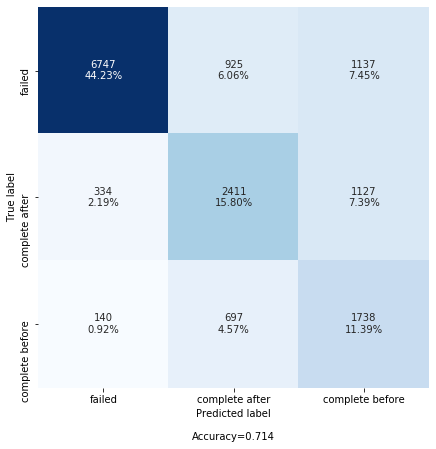

In [118]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, drop_features=to_remove1, labels_compact=labelling, **{'depth': 7, 'l2_leaf_reg': 1, 'learning_rate': 0.01})

In [93]:
df

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer,label
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,1
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1.0,2.0,2.0,2.0,2.0,2.0,17.78,1.00,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,0.00,NaN,NaN,NaN,NaN,,,,,,,0.758621,5.50,1.75,19.89,17.78,3.616364,10.160000,0
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0.0,1.0,2.0,5.0,5.0,5.0,23.93,1.25,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,87.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,NaN,NaN,j,,,,,,0.318841,5.50,11.75,19.89,91.10,3.616364,7.753191,1
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,5.25,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,0.00,NaN,j,,b,,,,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739,1
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,9fcbff4f8d7241faa4ab8a9d19c8a812,47.0,94000.0,-286,1,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,21.0,3,4,11,2017,0.00,0.00,0.00,0.00,0.00,0.00,0

In [ ]:
cat_features=[0,4,5,]

In [101]:
cat_features_name = ['person', 'gender', 'id', 'offer_7', 'offer_14', 'offer_17', 'offer_21', 'offer_24', 'offer_30', 'cunt']

In [102]:
[df.columns.get_loc(x) for x in cat_features_name if x in df.columns]

[0, 4, 5, 92, 93, 94, 95, 96, 97]

In [103]:
cat_features = [df.columns.get_loc(i) for i in cat_features_name if i in df.columns]

In [104]:
cat_features

[0, 4, 5, 92, 93, 94, 95, 96, 97]

# Person split importances comparison

#### Person split, all features

In [31]:
df = feature_transformer()
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'person')
cv = cv_method(X_train, y_train, 'person')
grid = best_param_grid('grid_search_corrected_person_split_27_10', metric='logloss_mean', folds=5)
importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)
joblib.dump(importance_results, '../../models/importance_person_all_features_new.joblib', compress=True)
importance_results_list.append()

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Training with {'learning_rate': [0.07], 'max_depth': [10]}
positive classification % per fold and length
train[0] 0.4402 (48849,)
test[0]  0.4346 (12213,)
train[1] 0.44 (48849,)
test[1]  0.4352 (12213,)
train[2] 0.4393 (48850,)
test[2]  0.438 (12212,)
train[3] 0.4386 (48850,)
test[3]  0.441 (12212,)
train[4] 0.4372 (48850,)
test[4]  0.4464 (12212,)
0:	learn: 0.6122931	test: 0.6577887	best: 0.6577887 (0)	total: 530ms	remaining: 26m 29s


KeyboardInterrupt: 

#### Person split, no features

In [472]:
df = feature_transformer(remove=[t, hist, day, last])
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'person')
cv = cv_method(X_train, y_train, 'person')
grid = best_param_grid('grid_search_person_no_feaures_27_10_', metric='logloss_mean', folds=5)
importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)
joblib.dump(importance_results, '../../models/importance_person_no_features_new.joblib', compress=True)

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Training with {'learning_rate': [0.03], 'max_depth': [7]}
positive classification % per fold and length
train[0] 0.4402 (48849,)
test[0]  0.4346 (12213,)
train[1] 0.44 (48849,)
test[1]  0.4352 (12213,)
train[2] 0.4393 (48850,)
test[2]  0.438 (12212,)
train[3] 0.4386 (48850,)
test[3]  0.441 (12212,)
train[4] 0.4372 (48850,)
test[4]  0.4464 (12212,)
0:	learn: 0.6627580	test: 0.6654024	best: 0.6654024 (0)	total: 124ms	remaining: 6m 10s


KeyboardInterrupt: 

#### Time split, all features

In [474]:
df = feature_transformer()
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')
cv = cv_method(X_train, y_train, 'time')
grid = best_param_grid('grid_search__time_series_27_10_fold', metric='logloss_mean', folds=5)
importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)
joblib.dump(importance_results, '../../models/importance_time_series_all_features_new.joblib', compress=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Training with {'learning_rate': [0.01], 'max_depth': [7]}
positive classification % per fold and length
train[0] 0.3988 (10171,)
test[0]  0.4224 (10170,)
train[1] 0.4106 (20341,)
test[1]  0.4496 (10170,)
train[2] 0.4236 (30511,)
test[2]  0.4618 (10170,)
train[3] 0.4331 (40681,)
test[3]  0.4679 (10170,)
train[4] 0.4401 (50851,)
test[4]  0.4674 (10170,)
0:	learn: 0.6841760	test: 0.6843216	best: 0.6843216 (0)	total: 112ms	remaining: 5m 35s


KeyboardInterrupt: 

# TESTING extra features

In [14]:
df = feature_transformer(file='../../data/interim/transcript_final_optimised_11-20_20_43_07.joblib')
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')
cv = cv_method(X_train, y_train, 'time')
grid = best_param_grid('grid_search__time_series_27_10_fold', metric='logloss_mean', folds=5)
importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)
joblib.dump(importance_results, '../../models/importance_time_serie_EXTRA_FEATURES_TEST.joblib', compress=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Training with {'learning_rate': [0.01], 'max_depth': [7]}
positive classification % per fold and length
train[0] 0.3988 (10171,)
test[0]  0.4224 (10170,)
train[1] 0.4106 (20341,)
test[1]  0.4496 (10170,)
train[2] 0.4236 (30511,)
test[2]  0.4618 (10170,)
train[3] 0.4331 (40681,)
test[3]  0.4679 (10170,)
train[4] 0.4401 (50851,)
test[4]  0.4674 (10170,)
0:	learn: 0.6845197	test: 0.6847364	best: 0.6847364 (0)	total: 101ms	remaining: 5m 2s
400:	learn: 0.4180130	test: 0.4258659	best: 0.4258659 (400)	total: 42.5s	remaining: 4m 35s
800:	learn: 0.4085894	test: 0.4234688	best: 0.4234688 (800)	total: 1m 30s	remaining: 4m 8s
bestTest = 0.4230119703
bestIteration = 1059
Shrink model to first 1060 iterations.
0:	learn: 0.6832676	test: 0.6838406	best: 0.6838406 (0)	total: 627ms	remaining: 31m 19s
400:	learn: 0.3357289	test: 0.3685555	best: 0.3685555 (400)	total: 2m 20s	remaining: 15m 8s
800:	learn: 0.3143291	test: 0.3606142	best: 0.3604876 (799)	total: 3m 33s	remaining: 9m 45s
bestTest = 0.359484179

['../../models/importance_time_serie_EXTRA_FEATURES_TEST.joblib']

#### Time split, no features

In [478]:
df = feature_transformer(remove=[t, hist, day, last])
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')
cv = cv_method(X_train, y_train, 'time')
grid = best_param_grid('grid_search__time_series_no_features_27_10_fold', metric='logloss_mean', folds=5)
importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)
joblib.dump(importance_results, '../../models/importance_time_series_no_features_new.joblib', compress=True)

Training with {'learning_rate': [0.01], 'max_depth': [10]}
positive classification % per fold and length
train[0] 0.3988 (10171,)
test[0]  0.4224 (10170,)
train[1] 0.4106 (20341,)
test[1]  0.4496 (10170,)
train[2] 0.4236 (30511,)
test[2]  0.4618 (10170,)
train[3] 0.4331 (40681,)
test[3]  0.4679 (10170,)
train[4] 0.4401 (50851,)
test[4]  0.4674 (10170,)
0:	learn: 0.6843650	test: 0.6844825	best: 0.6844825 (0)	total: 335ms	remaining: 16m 44s


KeyboardInterrupt: 

In [20]:
df = feature_transformer(file='../../data/interim/transcript_final_optimised_11-20_20_43_07.joblib')
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6813203	test: 0.6820042	best: 0.6820042 (0)	total: 57.5ms	remaining: 2m 52s
200:	learn: 0.2722617	test: 0.3797837	best: 0.3797837 (200)	total: 12.8s	remaining: 2m 58s
400:	learn: 0.2054643	test: 0.3697968	best: 0.3697968 (400)	total: 24.6s	remaining: 2m 39s
600:	learn: 0.1866811	test: 0.3622980	best: 0.3622980 (600)	total: 36.4s	remaining: 2m 25s
800:	learn: 0.1706738	test: 0.3559024	best: 0.3559024 (800)	total: 48.1s	remaining: 2m 12s
1000:	learn: 0.1581533	test: 0.3508723	best: 0.3508723 (1000)	total: 1m	remaining: 2m 1s
1200:	learn: 0.1443746	test: 0.3473706	best: 0.3473706 (1200)	total: 1m 14s	remaining: 1m 52s
1400:	learn: 0.1240337	test: 0.3446005	best: 0.3445613 (1385)	total: 1m 44s	remaining: 1m 59s
1600:	learn: 0.1177492	test: 0.3443030	best: 0.3441053 (1558)	total: 2m 10s	remaining: 1m 53s
bestTest = 0.3441052649
bestIteration = 1558
Shrink model to first 1559 iterations.
[[6953 1856]
 [ 520 5927]]  accuracy:   0.8443  log_loss:  0.3441

              precision   

0.844257996853697

In [44]:
cat_features = [0,4,5,92,93,94,95,96,97]

In [35]:
[1,2,3,4,5][0:2]

[1, 2]

In [33]:
[0,4,5,92:98]

SyntaxError: invalid syntax (<ipython-input-33-3ebdb9243635>, line 1)

In [29]:
feature_transformer(file='../../data/interim/transcript_final_optimised.joblib').shape

(76277, 99)

In [41]:
feature_transformer(file='../../data/interim/transcript_final_optimised.joblib').iloc[:,92:98]

,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30
0,,,,,,
16954,,,,,,
46985,,,,,,
16949,,,,,,
46990,,,,,,
...,...,...,...,...,...,...
44950,,,,h,,
44947,a,g,a,c,,
44941,d,d,f,h,,
44929,b,g,,,,


# Trying final features - all incremental features

In [45]:
df = feature_transformer(file='../../data/interim/transcript_final_optimised.joblib')
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6815586	test: 0.6818439	best: 0.6818439 (0)	total: 70.8ms	remaining: 3m 32s
200:	learn: 0.2738624	test: 0.3804584	best: 0.3804584 (200)	total: 13s	remaining: 3m 1s
400:	learn: 0.2185601	test: 0.3696585	best: 0.3696585 (400)	total: 26.6s	remaining: 2m 52s
600:	learn: 0.1973040	test: 0.3623463	best: 0.3623463 (600)	total: 50.5s	remaining: 3m 21s
800:	learn: 0.1845429	test: 0.3584055	best: 0.3584055 (800)	total: 1m 14s	remaining: 3m 23s
1000:	learn: 0.1760681	test: 0.3548441	best: 0.3548441 (1000)	total: 1m 53s	remaining: 3m 47s
1200:	learn: 0.1660334	test: 0.3525159	best: 0.3525159 (1200)	total: 2m 33s	remaining: 3m 49s
1400:	learn: 0.1518415	test: 0.3504494	best: 0.3504404 (1398)	total: 3m 19s	remaining: 3m 47s
1600:	learn: 0.1400089	test: 0.3481402	best: 0.3481402 (1600)	total: 3m 54s	remaining: 3m 24s
1800:	learn: 0.1256920	test: 0.3467016	best: 0.3467016 (1800)	total: 4m 24s	remaining: 2m 56s
2000:	learn: 0.1101333	test: 0.3462321	best: 0.3462321 (2000)	total: 4m 53s	rema

0.8443235448348191

In [49]:
0.8443235448348191-0.844257996853697

6.554798112212712e-05

In [46]:
df = feature_transformer(file='../../data/interim/transcript_final_optimised.joblib')
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=8,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6817086	test: 0.6820483	best: 0.6820483 (0)	total: 199ms	remaining: 9m 56s
200:	learn: 0.2539393	test: 0.3777936	best: 0.3777936 (200)	total: 39.5s	remaining: 9m 10s
400:	learn: 0.2013209	test: 0.3659594	best: 0.3659208 (398)	total: 1m 7s	remaining: 7m 20s
600:	learn: 0.1795487	test: 0.3604652	best: 0.3604591 (598)	total: 1m 32s	remaining: 6m 8s
800:	learn: 0.1661995	test: 0.3572315	best: 0.3571734 (798)	total: 2m 3s	remaining: 5m 39s
1000:	learn: 0.1539197	test: 0.3540721	best: 0.3540314 (997)	total: 2m 50s	remaining: 5m 41s
1200:	learn: 0.1423769	test: 0.3516588	best: 0.3516588 (1200)	total: 4m 4s	remaining: 6m 6s
1400:	learn: 0.1314655	test: 0.3504738	best: 0.3504496 (1389)	total: 5m 23s	remaining: 6m 8s
1600:	learn: 0.1175988	test: 0.3495178	best: 0.3494764 (1591)	total: 6m 42s	remaining: 5m 51s
1800:	learn: 0.1083115	test: 0.3488122	best: 0.3486718 (1767)	total: 8m 1s	remaining: 5m 20s
bestTest = 0.3482835647
bestIteration = 1948
Shrink model to first 1949 iterations.


0.8428159412690089

In [47]:
df = feature_transformer(file='../../data/interim/transcript_final_optimised.joblib')
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=6,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6813406	test: 0.6817089	best: 0.6817089 (0)	total: 227ms	remaining: 11m 21s
200:	learn: 0.2838831	test: 0.3844249	best: 0.3844249 (200)	total: 23.8s	remaining: 5m 31s
400:	learn: 0.2382704	test: 0.3740150	best: 0.3740150 (400)	total: 37.3s	remaining: 4m 1s
600:	learn: 0.2166287	test: 0.3676924	best: 0.3676804 (599)	total: 51s	remaining: 3m 23s
800:	learn: 0.2010009	test: 0.3632672	best: 0.3632518 (798)	total: 1m 5s	remaining: 2m 59s
1000:	learn: 0.1929768	test: 0.3600049	best: 0.3599996 (999)	total: 1m 23s	remaining: 2m 47s
1200:	learn: 0.1847832	test: 0.3572420	best: 0.3572106 (1196)	total: 2m 4s	remaining: 3m 7s
1400:	learn: 0.1698171	test: 0.3545000	best: 0.3545000 (1400)	total: 2m 50s	remaining: 3m 14s
1600:	learn: 0.1618033	test: 0.3526042	best: 0.3526042 (1600)	total: 3m 36s	remaining: 3m 9s
1800:	learn: 0.1553468	test: 0.3512754	best: 0.3512754 (1800)	total: 4m 24s	remaining: 2m 55s
2000:	learn: 0.1295427	test: 0.3505275	best: 0.3505275 (2000)	total: 5m 12s	remaining

0.8411116937598322

In [ ]:
../../data/interim/transcript_final_optimised.joblib

In [23]:
df = feature_transformer(remove=[t, hist, day, last])
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6826886	test: 0.6823901	best: 0.6823901 (0)	total: 117ms	remaining: 5m 50s
200:	learn: 0.3736356	test: 0.3793546	best: 0.3793546 (200)	total: 22.5s	remaining: 5m 13s
400:	learn: 0.3548574	test: 0.3774848	best: 0.3770847 (355)	total: 46.6s	remaining: 5m 1s
bestTest = 0.377084669
bestIteration = 355
Shrink model to first 356 iterations.
[[7059 1750]
 [ 881 5566]]  accuracy:   0.8275  log_loss:  0.3771

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      8809
           1       0.76      0.86      0.81      6447

    accuracy                           0.83     15256
   macro avg       0.82      0.83      0.83     15256
weighted avg       0.83      0.83      0.83     15256



0.8275432616675407

In [25]:
.844258-.827543

0.016714999999999924

In [19]:
joblib.load('../../models/importance_time_serie_EXTRA_FEATURES_TEST.joblib')

,importance0,importance1,importance2
feature0,,,
person,22.3079,0.0244452,0.0175705
id,11.7046,0.0323475,0.037186
hist_reward_completed,9.07131,0.000946534,0.000888853
hist_failed_complete,9.04471,0.00642865,-0.00587903
hist_previous_offers,7.91627,0.00785904,-0.0066173
reward,6.62867,0.00456024,-0.00452449
difficulty,4.12023,0.00253025,-0.00520115
last_amount,3.12118,0.0016172,0.00279151
informational,3.0478,0.0011424,-0.00444539


In [20]:
df = feature_transformer(remove=[t, hist, day, last])

In [24]:
df.drop('person', inplace=True, axis=1)

In [32]:
df.id.value_counts()

6    7677
0    7668
1    7658
5    7646
4    7632
9    7618
8    7617
3    7597
2    7593
7    7571
Name: id, dtype: int64

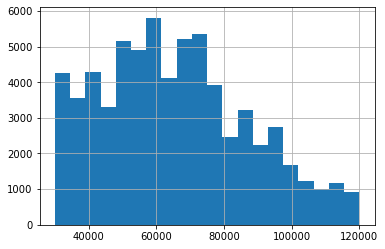

In [38]:
df.income.hist(bins=20)

In [41]:
df

,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,completed
0,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1
16954,38.0,48000.0,-129,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
46985,40.0,38000.0,-1527,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
16949,NaN,NaN,-814,0,2,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
46990,84.0,31000.0,-481,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44950,NaN,NaN,-429,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,24.0,0
44947,52.0,34000.0,-304,1,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,24.0,0
44941,33.0,37000.0,-112,1,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,24.0,0
44929,NaN,NaN,-90,0,3,0.0,10.0,2.0,10.0,1.0,1.0,1.0,0.0,1.0,0.0,24.0,0


In [42]:
df.drop(['rewarded',
        'difficulty',
        'reward',
        'duration',
        'mobile',
        'web',
        'social',
        'bogo',
        'discount',
        'informational'], axis=1, inplace=True)

<Figure size 720x720 with 0 Axes>

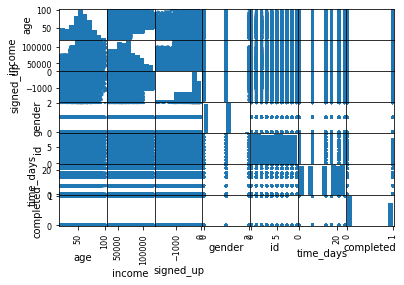

In [45]:
plt.figure(figsize=(10,10))
pd.plotting.scatter_matrix(df);

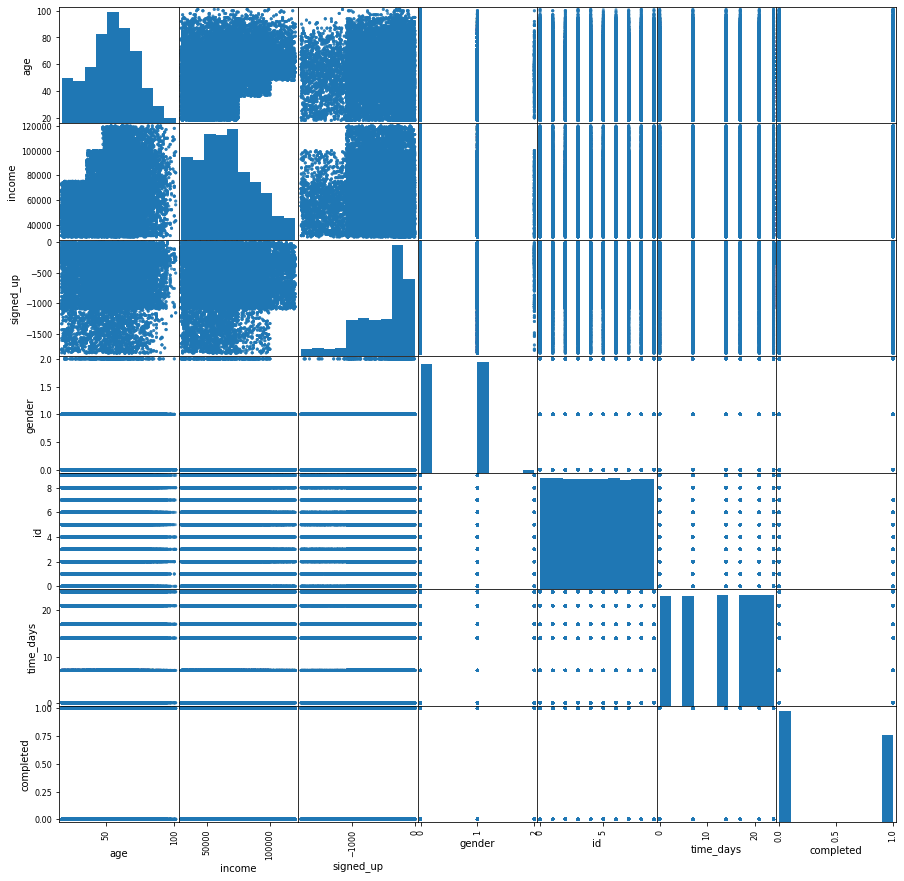

In [46]:
pd.plotting.scatter_matrix(df, figsize=(15,15));

In [51]:
df

,age,income,signed_up,gender,id,time_days,completed
0,75.0,100000.0,-443,0,6,0.0,1
16954,38.0,48000.0,-129,0,7,0.0,0
46985,40.0,38000.0,-1527,1,6,0.0,0
16949,NaN,NaN,-814,0,2,0.0,0
46990,84.0,31000.0,-481,0,8,0.0,0
...,...,...,...,...,...,...,...
44950,NaN,NaN,-429,0,7,24.0,0
44947,52.0,34000.0,-304,1,7,24.0,0
44941,33.0,37000.0,-112,1,8,24.0,0
44929,NaN,NaN,-90,0,3,24.0,0


In [48]:
import pandas_profiling

In [49]:
pandas_profiling.ProfileReport(df)

In [ ]:
df.corr()

# < -------- OLD METHOD TO BE REPLACED -------- >

# Person split importances comparison

In [ ]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)

# test df
#df = df[0:1000]

X = df.drop('completed', axis=1)
y = df.completed

cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
X_train=X_train[0]
y_train=y_train[0]
X_test=X_test[0]
y_test=y_test[0]

results_person, best_scores = grid_search_results('grid_search_corrected_person_split_27_10', 5, display_results=False)
grid = best_scores[best_scores.Metric == 'logloss_mean'].Params[0]
grid['learning_rate'] = [grid['learning_rate']]
grid['max_depth'] = [grid['max_depth']]

# test grid
#grid = {'learning_rate': [0.5], 'max_depth': [5]}

print(grid)

cat_features = [0, 4, 5]
cv = GroupKFold(n_splits=5).split(X_train, y_train, groups=X_train.person)
folds = list(range(0,5))

importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)

'''
list_occurences =[]
for i in range(len(importance_results)):
    list_occurences.extend(importance_results[i][importance_results[i].importance2 <0].index)
negative_counts = pd.Series(list_occurences).value_counts()
'''

joblib.dump(importance_results, '../../models/importance_person_all_features_new.joblib', compress=True)

#### Person split importances no features comparison

In [8]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df = remove_features(df, [t, hist, day, last])

# test df
#df = df[0:1000]

X = df.drop('completed', axis=1)
y = df.completed

cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
X_train=X_train[0]
y_train=y_train[0]
X_test=X_test[0]
y_test=y_test[0]

results_person, best_scores = grid_search_results('grid_search_person_no_feaures_27_10_', 5, display_results=False)
grid = best_scores[best_scores.Metric == 'logloss_mean'].Params[0]
grid['learning_rate'] = [grid['learning_rate']]
grid['max_depth'] = [grid['max_depth']]

# test grid
#grid = {'learning_rate': [0.5], 'max_depth': [5]}

print(grid)

cat_features = [0, 4, 5]
cv = GroupKFold(n_splits=5).split(X_train, y_train, groups=X_train.person)
#folds = list(range(0,5))

importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)

'''
list_occurences =[]
for i in range(len(importance_results)):
    list_occurences.extend(importance_results[i][importance_results[i].importance2 <0].index)
negative_counts = pd.Series(list_occurences).value_counts()
'''

joblib.dump(importance_results, '../../models/importance_person_no_features_new.joblib', compress=True)

positive classification % per fold and length
train[0] 0.4868 (793,)
test[0]  0.3092 (207,)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'learning_rate': [0.5], 'max_depth': [5]}
positive classification % per fold and length
train[0] 0.4685 (634,)
test[0]  0.5597 (159,)
train[1] 0.4968 (634,)
test[1]  0.4465 (159,)
train[2] 0.4826 (634,)
test[2]  0.5031 (159,)
train[3] 0.4882 (635,)
test[3]  0.481 (158,)
train[4] 0.4976 (635,)
test[4]  0.443 (158,)
0:	learn: 0.4808269	test: 0.5244468	best: 0.5244468 (0)	total: 48.1ms	remaining: 2m 24s
bestTest = 0.4339115455
bestIteration = 10
Shrink model to first 11 iterations.
0:	learn: 0.4831915	test: 0.5173383	best: 0.5173383 (0)	total: 45.6ms	remaining: 2m 16s
bestTest = 0.4734416938
bestIteration = 4
Shrink model to first 5 iterations.
0:	learn: 0.4935210	test: 0.4921348	best: 0.4921348 (0)	total: 51.6ms	remaining: 2m 34s
bestTest = 0.3844124176
bestIteration = 6
Shrink model to first 7 iterations.
0:	learn: 0.4703166	test: 0.5598548	best: 0.5598548 (0)	total: 45ms	remaining: 2m 15s
bestTest = 0.5323431281
bestIteration = 3
Shrink model to first 4 iterations.
0:	learn: 0.4763161

['../../models/importance_person_no_features.joblib']

#### Time Series Split importances comparison

In [9]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)

# test df
#df = df[0:1000]

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

results_person, best_scores = grid_search_results('grid_search__time_series_27_10_fold', 5, display_results=False)
grid = best_scores[best_scores.Metric == 'logloss_mean'].Params[0]
grid['learning_rate'] = [grid['learning_rate']]
grid['max_depth'] = [grid['max_depth']]

# test grid
#grid = {'learning_rate': [0.5], 'max_depth': [5]}

print(grid)

cat_features = [0, 4, 5]
cv = TimeSeriesSplit(n_splits=5).split(X_train, y_train)
folds = list(range(0,5))

importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)

'''
list_occurences =[]
for i in range(len(importance_results)):
    list_occurences.extend(importance_results[i][importance_results[i].importance2 <0].index)
negative_counts = pd.Series(list_occurences).value_counts()
'''

joblib.dump(importance_results, '../../models/importance_time_series_all_features_new.joblib', compress=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'learning_rate': [0.5], 'max_depth': [5]}
positive classification % per fold and length
train[0] 0.3778 (135,)
test[0]  0.3985 (133,)
train[1] 0.3881 (268,)
test[1]  0.3383 (133,)
train[2] 0.3716 (401,)
test[2]  0.3158 (133,)
train[3] 0.3577 (534,)
test[3]  0.3383 (133,)
train[4] 0.3538 (667,)
test[4]  0.3985 (133,)
0:	learn: 0.5057729	test: 0.6480837	best: 0.6480837 (0)	total: 54.1ms	remaining: 2m 42s
bestTest = 0.5836978425
bestIteration = 5
Shrink model to first 6 iterations.
0:	learn: 0.4656413	test: 0.5356715	best: 0.5356715 (0)	total: 73.8ms	remaining: 3m 41s
bestTest = 0.5257897054
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.4899582	test: 0.5259212	best: 0.5259212 (0)	total: 222ms	remaining: 11m 5s
bestTest = 0.4462895214
bestIteration = 33
Shrink model to first 34 iterations.
0:	learn: 0.4883213	test: 0.5494048	best: 0.5494048 (0)	total: 69ms	remaining: 3m 26s
bestTest = 0.5023887462
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.495391

['../../models/importance_time_series_all_features.joblib']

#### Time Series Split importances comparison, no features

In [10]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df = remove_features(df, [t, hist, day, last])

# test df
#df = df[0:1000]

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

results_person, best_scores = grid_search_results('grid_search__time_series_no_features_27_10_fold', 5, display_results=False)
grid = best_scores[best_scores.Metric == 'logloss_mean'].Params[0]
grid['learning_rate'] = [grid['learning_rate']]
grid['max_depth'] = [grid['max_depth']]

# test grid
#grid = {'learning_rate': [0.5], 'max_depth': [5]}

print(grid)

cat_features = [0, 4, 5]
cv = TimeSeriesSplit(n_splits=5).split(X_train, y_train)
folds = list(range(0,5))

importance_results = gridsearch_early_stopping_importance(cv, X_train, y_train, [0,1,2,3,4], grid, cat_features=cat_features)

'''
list_occurences =[]
for i in range(len(importance_results)):
    list_occurences.extend(importance_results[i][importance_results[i].importance2 <0].index)
negative_counts = pd.Series(list_occurences).value_counts()
'''

joblib.dump(importance_results, '../../models/importance_time_series_no_features_new.joblib', compress=True)

{'learning_rate': [0.5], 'max_depth': [5]}
positive classification % per fold and length
train[0] 0.3778 (135,)
test[0]  0.3985 (133,)
train[1] 0.3881 (268,)
test[1]  0.3383 (133,)
train[2] 0.3716 (401,)
test[2]  0.3158 (133,)
train[3] 0.3577 (534,)
test[3]  0.3383 (133,)
train[4] 0.3538 (667,)
test[4]  0.3985 (133,)
0:	learn: 0.4808161	test: 0.5042398	best: 0.5042398 (0)	total: 56.8ms	remaining: 2m 50s
bestTest = 0.4362934084
bestIteration = 3
Shrink model to first 4 iterations.
0:	learn: 0.4656413	test: 0.5356715	best: 0.5356715 (0)	total: 64.9ms	remaining: 3m 14s
bestTest = 0.5075279752
bestIteration = 4
Shrink model to first 5 iterations.
0:	learn: 0.4787477	test: 0.5201088	best: 0.5201088 (0)	total: 166ms	remaining: 8m 18s
bestTest = 0.4467672764
bestIteration = 11
Shrink model to first 12 iterations.
0:	learn: 0.4748705	test: 0.5135523	best: 0.5135523 (0)	total: 134ms	remaining: 6m 43s
bestTest = 0.4731152757
bestIteration = 6
Shrink model to first 7 iterations.
0:	learn: 0.50274

['../../models/importance_time_series_no_features.joblib']

# < -------- OLD METHOD TO BE REPLACED -------- >

In [330]:
# loading saved feature importances 
importance_person_all_features = joblib.load('../../models/importance_person_all_features_new.joblib')
importance_person_no_features = joblib.load('../../models/importance_person_no_features_new.joblib')
importance_time_all_features = joblib.load('../../models/importance_time_series_all_features_new.joblib')
importance_time_no_features = joblib.load('../../models/importance_time_series_no_features_new.joblib')

In [ ]:
importances_multi = joblib.load('../../models/importances_multi.joblib')

### Importance Metric Discussion
We have 3 importance  metrics:
* PredictionValues_Change
   * What percentage did this feature contribute to the model?
* LossFunctionChange - Train or Test
   * What affect does removing trees with these features have on our ability to predict train or test data
   
We will focus on LossFunctionChange against Testing data. In this case assuming that features that frequently have a bad effect on model predictive power should be removed.

In [72]:
def compare_importances(path='../../models/importance_person_all_features_new.joblib', method='importance2'):
    '''
    Takes importances for each cross validation fold and joins them in a DataFrame, calculating mean.
    Parameters
    -----------
    path: path to importance_results
    method: string
            'importance1': PredictionValues_Change
            'importance2': LossFunctionChange Train
            'importance3': LossFunctionChange Test
            
    Returns
    -----------
    df: DataFrame    
    '''
    fold_result_list = joblib.load(path)
    folds = len(fold_result_list)
    method_per_fold = [fold_result_list[i][method] for i in range(folds)]
    
    df = pd.DataFrame(method_per_fold).transpose() #rename(columns={'importance2' + str(i): 'fold' + str(i) for i in range(folds)})
    df['mean'] = df.sum(axis=1)/folds
    df.sort_values('mean', ascending=False, inplace=True)
    return df

In [77]:
importance_analysis

,importance2,importance2,importance2,importance2,importance2,mean
signed_up,8.219848e-02,2.583383e-02,3.953708e-02,4.652213e-02,1.526484e-02,4.187127e-02
id,2.418651e-02,3.608067e-02,1.544605e-02,2.410324e-02,8.815612e-03,2.172642e-02
hist_viewed_spend,0.000000e+00,5.961420e-03,8.274350e-03,2.438921e-02,1.152694e-02,1.003038e-02
income,2.242113e-02,5.108663e-03,7.427015e-03,5.403275e-03,5.535389e-03,9.179094e-03
person,3.799150e-05,2.265819e-03,1.715122e-02,1.450894e-02,8.054772e-03,8.403749e-03
amount_per_day_not_offer,5.065076e-04,3.820292e-02,-2.203450e-05,-3.113190e-04,3.491788e-04,7.745051e-03
month,2.287255e-02,-1.964931e-05,1.582993e-02,-4.782408e-06,-1.918933e-05,7.731772e-03
t_21,0.000000e+00,1.916778e-03,4.595864e-04,1.583231e-02,1.222063e-02,6.085861e-03
hist_received_spend,0.000000e+00,5.284359e-04,4.001603e-04,1.680750e-02,8.652206e-03,5.277661e-03
day,2.410354e-02,2.194466e-05,-1.263557e-05,3.838388e-05,8.763249e-05,4.847773e-03


In [76]:
importance_analysis = compare_importances(path='../../models/importances_multi.joblib', method='importance2')

In [80]:
to_remove = importance_analysis[importance_analysis['mean'] <0].index

In [116]:
importance_analysis1 = compare_importances(path='../../models/importances_multi.joblib', method='importance1')
to_remove1 = importance_analysis[importance_analysis1['mean'] < 1*10**-7].index

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [115]:
1*10**-7

1e-07

In [117]:
to_remove1

Index(['count_3', 'count_9', 'amount_30', 'count_8', 'rewarded', 'offer_30',
       'offer_24', 'offer_21', 'amount_24'],
      dtype='object')

In [109]:
importance_analysis0 = compare_importances(path='../../models/importances_multi.joblib', method='importance0')
to_remove0 = importance_analysis[importance_analysis0['mean'] <0].index

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [112]:
importance_analysis1

,importance1,importance1,importance1,importance1,importance1,mean
signed_up,7.683709e-02,3.575624e-02,2.864183e-02,0.028106,0.006971,3.526241e-02
person,-5.027569e-04,1.789952e-02,4.853582e-02,0.018509,0.035702,2.402877e-02
id,2.179610e-02,4.021593e-02,1.334270e-02,0.019651,0.009719,2.094488e-02
hist_viewed_spend,0.000000e+00,1.865747e-02,3.444210e-03,0.020367,0.033765,1.524685e-02
amount_per_day_not_offer,1.110223e-16,5.792089e-02,5.332715e-04,0.000168,0.000228,1.176994e-02
t_21,0.000000e+00,9.966776e-04,3.550293e-04,0.016686,0.031106,9.828908e-03
hist_viewed_and_completed,0.000000e+00,9.504309e-05,4.837656e-02,0.000022,0.000267,9.752014e-03
income,1.953607e-02,5.666306e-03,6.504410e-03,0.003417,0.002285,7.481871e-03
month,2.146276e-02,1.004399e-04,1.310691e-02,0.000071,0.000085,6.965243e-03
hist_failed_complete,0.000000e+00,5.661876e-04,1.008635e-03,0.023979,0.008856,6.881935e-03


In [515]:
importance_file_paths = ['../../models/importance_person_all_features_new.joblib',
                    '../../models/importance_person_no_features_new.joblib',
                    '../../models/importance_time_series_all_features_new.joblib',
                    '../../models/importance_time_series_no_features_new.joblib']

In [585]:
mean_importances = []
for i in importance_file_paths:
    mean_importances.append(compare_importances(path=i, method='importance2'))
    mean_per_fold = [mean_importances[i]['mean'].rename(i) for i in range(len(mean_importances))]
    df = pd.DataFrame(mean_per_fold).transpose()
df['experiments_mean'] = df.sum(axis=1)
df.sort_values('experiments_mean', ascending=False, inplace=True)
df.rename(columns={0:'person_all', 1:'person_none', 2:'time_all', 3:'time_none'}, inplace=True)

## Here we can see the features by order of their effect on the predictability of the model
* I've taken an average of the 4 experiments across 5 folds with optimal paramters to give a meta score for each parameter. 
* We can test removal of negative features to see if these can yield any improvement in accuracy

In [586]:
cm = sns.light_palette("green", as_cmap=True)
df.style.set_caption('Average ')\
    .background_gradient(cmap=cm)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,person_all,person_none,time_all,time_none,experiments_mean
id,0.268985,0.279191,0.125157,0.206353,0.879686
signed_up,0.067429,0.17493,0.140164,0.113295,0.495818
hist_viewed_spend,0.353481,nan,0.120533,nan,0.474014
income,0.0320412,0.0955194,0.0484535,0.202111,0.378125
time_days,0.00092653,0.293878,-0.00550038,0.0874546,0.376759
informational,0.0284382,0.111659,0.0206367,0.0601177,0.220852
age,0.0346572,0.0418586,0.0705244,0.0578752,0.204915
last_amount,0.0103748,nan,0.0900665,nan,0.100441
person,-0.0061047,0.00209292,0.0509309,0.0380872,0.0850063
reward,0.0126354,0.0270107,-0.000207671,0.0398298,0.0792682


In [618]:
offer_overlap_features = joblib.load('../../data/interim/overlap_features.joblib')

In [620]:
offer_overlap_features.shape

(76277, 9)

In [621]:
df = joblib.load('../../data/interim/transcript_final.joblib')

In [627]:
df = df.join(offer_overlap_features)

In [588]:
best_param_grid('grid_search__time_series_27_10_fold', metric='logloss_mean', folds=5)

Training with {'learning_rate': [0.01], 'max_depth': [7]}


{'learning_rate': [0.01], 'max_depth': [7]}

In [595]:
list = ['hist_complete_not_viewed', 
        'web'
      'day', 
      'hist_viewed',
      'hist_viewed_and_completed',
      'hist_reward_possible',
      'hist_failed_complete'
     ]

In [596]:
list[0]

'hist_complete_not_viewed'

# testing with overlap features

In [630]:
df = feature_transformer()
df = df.join(offer_overlap_features)
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6811211	test: 0.6820071	best: 0.6820071 (0)	total: 74.8ms	remaining: 3m 44s
200:	learn: 0.2823354	test: 0.3802120	best: 0.3802120 (200)	total: 11.4s	remaining: 2m 38s
400:	learn: 0.2158986	test: 0.3703179	best: 0.3703179 (400)	total: 23s	remaining: 2m 28s
600:	learn: 0.1971343	test: 0.3627243	best: 0.3627116 (598)	total: 54.8s	remaining: 3m 38s
800:	learn: 0.1702965	test: 0.3568998	best: 0.3568998 (800)	total: 1m 30s	remaining: 4m 8s
1000:	learn: 0.1481182	test: 0.3530756	best: 0.3530756 (1000)	total: 2m 12s	remaining: 4m 24s
1200:	learn: 0.1312493	test: 0.3514423	best: 0.3514423 (1200)	total: 2m 52s	remaining: 4m 18s
bestTest = 0.3513960696
bestIteration = 1203
Shrink model to first 1204 iterations.
[[6891 1918]
 [ 519 5928]]  accuracy:   0.8403  log_loss:  0.3514

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
           1       0.76      0.92      0.83      6447

    accuracy                           0.84    

0.8402595700052439

In [631]:
df = feature_transformer()
df = df.join(offer_overlap_features)
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=8,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6795645	test: 0.6820724	best: 0.6820724 (0)	total: 202ms	remaining: 10m 6s
200:	learn: 0.2503948	test: 0.3774844	best: 0.3774620 (199)	total: 29.3s	remaining: 6m 47s
400:	learn: 0.2008575	test: 0.3657494	best: 0.3657494 (400)	total: 46.5s	remaining: 5m 1s
600:	learn: 0.1704424	test: 0.3562274	best: 0.3562274 (600)	total: 1m 3s	remaining: 4m 14s
800:	learn: 0.1444772	test: 0.3506381	best: 0.3506381 (800)	total: 1m 21s	remaining: 3m 42s
1000:	learn: 0.1189648	test: 0.3479178	best: 0.3479178 (1000)	total: 1m 38s	remaining: 3m 17s
bestTest = 0.3478812511
bestIteration = 1003
Shrink model to first 1004 iterations.
[[6940 1869]
 [ 544 5903]]  accuracy:   0.8418  log_loss:  0.3479

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      8809
           1       0.76      0.92      0.83      6447

    accuracy                           0.84     15256
   macro avg       0.84      0.85      0.84     15256
weighted avg       0.86      0.8

0.8418327215521761

In [635]:
df = feature_transformer()
df = df.join(offer_overlap_features)
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'person')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.6773670	test: 0.6878716	best: 0.6878716 (0)	total: 137ms	remaining: 6m 51s
200:	learn: 0.2382763	test: 0.5110739	best: 0.5105747 (197)	total: 24s	remaining: 5m 33s
400:	learn: 0.1850800	test: 0.4868984	best: 0.4868984 (400)	total: 1m 10s	remaining: 7m 40s
600:	learn: 0.1401171	test: 0.4469928	best: 0.4469928 (600)	total: 2m 21s	remaining: 9m 24s
800:	learn: 0.1098244	test: 0.4274560	best: 0.4274560 (800)	total: 2m 59s	remaining: 8m 13s
bestTest = 0.4267263622
bestIteration = 813
Shrink model to first 814 iterations.
[[5702 2743]
 [ 579 6191]]  accuracy:   0.7817  log_loss:  0.4267

              precision    recall  f1-score   support

           0       0.91      0.68      0.77      8445
           1       0.69      0.91      0.79      6770

    accuracy                           0.78     15215
   macro avg       0.80      0.79      0.78     15215
weighted avg       0.81      0.78

0.7816628327308577

In [601]:
list = ['hist_complete_not_viewed', 
      'day', 
      'hist_viewed',
      'hist_viewed_and_completed',
      'hist_reward_possible',
      'hist_failed_complete'
     ]


for i in range(len(list)):
    df = feature_transformer(remove=[[list[i]]])
    df = df.join(offer_overlap_features)
    X, y = set_target(df, target='completed')
    X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=3000,
        max_depth=7,
        learning_rate =.01,
        early_stopping_rounds=50,
        custom_loss=['AUC', 'Accuracy'],
        task_type='GPU',
        cat_features=cat_features,
        verbose=False)

    model.fit(train_pool,
          eval_set=test_pool,
          verbose=200,
          plot=False);

    accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
    print(i)
    accuracy

0:	learn: 0.6813093	test: 0.6819817	best: 0.6819817 (0)	total: 74.8ms	remaining: 3m 44s
200:	learn: 0.2627598	test: 0.3802417	best: 0.3802417 (200)	total: 12.7s	remaining: 2m 57s
400:	learn: 0.2091386	test: 0.3698338	best: 0.3698338 (400)	total: 29s	remaining: 3m 8s
600:	learn: 0.1871130	test: 0.3630866	best: 0.3630765 (599)	total: 41.8s	remaining: 2m 46s
800:	learn: 0.1641005	test: 0.3575309	best: 0.3575309 (800)	total: 55.7s	remaining: 2m 32s
1000:	learn: 0.1380706	test: 0.3538312	best: 0.3538014 (996)	total: 1m 24s	remaining: 2m 49s
bestTest = 0.3531494781
bestIteration = 1101
Shrink model to first 1102 iterations.
[[6856 1953]
 [ 519 5928]]  accuracy:   0.838  log_loss:  0.3531

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
           1       0.75      0.92      0.83      6447

    accuracy                           0.84     15256
   macro avg       0.84      0.85      0.84     15256
weighted avg       0.85      0.84   

In [603]:
list = ['hist_complete_not_viewed', 
      'day', 
      'hist_viewed',
      'hist_viewed_and_completed',
      'hist_reward_possible',
      'hist_failed_complete'
     ]


for i in range(len(list)):
    df = feature_transformer(remove=[[list[i]]])
    X, y = set_target(df, target='completed')
    X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'person')

    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=3000,
        max_depth=10,
        learning_rate =.07,
        early_stopping_rounds=50,
        custom_loss=['AUC', 'Accuracy'],
        task_type='GPU',
        cat_features=cat_features,
        verbose=False)

    model.fit(train_pool,
          eval_set=test_pool,
          verbose=200,
          plot=False);

    accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
    print(i)
    accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.6134299	test: 0.6504700	best: 0.6504700 (0)	total: 126ms	remaining: 6m 19s
bestTest = 0.4313220147
bestIteration = 101
Shrink model to first 102 iterations.
[[5403 3042]
 [ 407 6363]]  accuracy:   0.7733  log_loss:  0.4313

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      8445
           1       0.68      0.94      0.79      6770

    accuracy                           0.77     15215
   macro avg       0.80      0.79      0.77     15215
weighted avg       0.82      0.77      0.77     15215

0
positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.6134299	test: 0.6504700	best: 0.6504700 (0)	total: 110ms	remaining: 5m 31s
200:	learn: 0.0688125	test: 0.3998789	best: 0.3998789 (200)	total: 56.4s	remaining: 13m 5s
bestTest = 0.393363547
bestIteration = 348
Shrink model to first 349 

In [604]:
df = feature_transformer()
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'person')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.07,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
print(i)
accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.5915893	test: 0.6595462	best: 0.6595462 (0)	total: 709ms	remaining: 35m 25s
bestTest = 0.4182339912
bestIteration = 131
Shrink model to first 132 iterations.
[[5968 2477]
 [ 688 6082]]  accuracy:   0.792  log_loss:  0.4182

              precision    recall  f1-score   support

           0       0.90      0.71      0.79      8445
           1       0.71      0.90      0.79      6770

    accuracy                           0.79     15215
   macro avg       0.80      0.80      0.79     15215
weighted avg       0.81      0.79      0.79     15215

5


0.791981597108117

In [605]:

        
list = [['day', 
      'hist_viewed',
      'hist_reward_possible',
      'hist_failed_complete'
     ]]


df = feature_transformer(remove=list)
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'person')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.07,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)

accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.6136807	test: 0.6516148	best: 0.6516148 (0)	total: 160ms	remaining: 7m 59s
200:	learn: 0.0963749	test: 0.4249179	best: 0.4210141 (163)	total: 24.3s	remaining: 5m 38s
400:	learn: 0.0504865	test: 0.4033528	best: 0.4014457 (385)	total: 48.5s	remaining: 5m 14s
bestTest = 0.401445749
bestIteration = 385
Shrink model to first 386 iterations.
[[6215 2230]
 [ 737 6033]]  accuracy:   0.805  log_loss:  0.4014

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      8445
           1       0.73      0.89      0.80      6770

    accuracy                           0.80     15215
   macro avg       0.81      0.81      0.80     15215
weighted avg       0.82      0.80      0.81     15215



0.8049950706539599

In [602]:
df = feature_transformer()
X, y = set_target(df, target='completed')
X_train, X_test, y_train, y_test = train_test_splitting_method(X, y, 'time')

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
print(i)
accuracy

0:	learn: 0.6811000	test: 0.6819986	best: 0.6819986 (0)	total: 242ms	remaining: 12m 6s
200:	learn: 0.2785145	test: 0.3805715	best: 0.3805715 (200)	total: 26.7s	remaining: 6m 11s
400:	learn: 0.2080761	test: 0.3709107	best: 0.3709107 (400)	total: 42.2s	remaining: 4m 33s
600:	learn: 0.1928695	test: 0.3624205	best: 0.3624205 (600)	total: 57.4s	remaining: 3m 49s
800:	learn: 0.1693460	test: 0.3571776	best: 0.3571776 (800)	total: 1m 12s	remaining: 3m 18s
1000:	learn: 0.1450615	test: 0.3527266	best: 0.3527266 (1000)	total: 1m 27s	remaining: 2m 54s
1200:	learn: 0.1276768	test: 0.3511317	best: 0.3511261 (1198)	total: 1m 46s	remaining: 2m 39s
1400:	learn: 0.1195785	test: 0.3495434	best: 0.3494141 (1387)	total: 2m 1s	remaining: 2m 18s
bestTest = 0.3494140753
bestIteration = 1387
Shrink model to first 1388 iterations.
[[6903 1906]
 [ 533 5914]]  accuracy:   0.8401  log_loss:  0.3494

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
       

0.8401284740429995

In [565]:
df.sort_values('3', axis=1, ascending=False)

KeyError: '3'

In [568]:
df['meaning'] = df.sum(axis=1)

In [569]:
df.meaning

hist_viewed_spend            0.948027
id                           1.759372
signed_up                    0.991636
hist_received_spend          0.121710
age                          0.409831
income                       0.756251
informational                0.441704
duration                     0.127953
reward                       0.158536
gender                       0.093482
last_amount                  0.200883
t_14                         0.043349
t_3                          0.103350
t_30c                        0.011859
t_30                         0.013387
hist_reward_completed        0.016809
t_21c                        0.007957
t_21                         0.013361
t_1                          0.036596
last_transaction_days        0.005197
year                         0.007027
time_days                    0.753518
bogo                         0.003377
t_1c                         0.000477
t_3c                         0.000520
rewarded                     0.000000
weekday     

In [560]:
df

,0,1,2,3,mean
hist_viewed_spend,0.353481,NaN,0.120533,NaN,0.474014
id,0.268985,0.279191,0.125157,0.206353,0.879686
signed_up,0.067429,0.174930,0.140164,0.113295,0.495818
hist_received_spend,0.059759,NaN,0.001095,NaN,0.060855
age,0.034657,0.041859,0.070524,0.057875,0.204915
income,0.032041,0.095519,0.048453,0.202111,0.378125
informational,0.028438,0.111659,0.020637,0.060118,0.220852
duration,0.014983,0.022191,-0.003084,0.029887,0.063976
reward,0.012635,0.027011,-0.000208,0.039830,0.079268
gender,0.012358,0.009080,0.005735,0.019568,0.046741


In [548]:
mean_per_fold[1].head(10)

hist_viewed_spend      0.353481
id                     0.268985
signed_up              0.067429
hist_received_spend    0.059759
age                    0.034657
income                 0.032041
informational          0.028438
duration               0.014983
reward                 0.012635
gender                 0.012358
Name: mean, dtype: float64

In [550]:
mean_per_fold[0].head(10)

hist_viewed_spend      0.353481
id                     0.268985
signed_up              0.067429
hist_received_spend    0.059759
age                    0.034657
income                 0.032041
informational          0.028438
duration               0.014983
reward                 0.012635
gender                 0.012358
Name: mean, dtype: float64

In [544]:
df

,mean,mean,mean,mean
hist_viewed_spend,0.353481,0.353481,0.353481,0.353481
id,0.268985,0.268985,0.268985,0.268985
signed_up,0.067429,0.067429,0.067429,0.067429
hist_received_spend,0.059759,0.059759,0.059759,0.059759
age,0.034657,0.034657,0.034657,0.034657
income,0.032041,0.032041,0.032041,0.032041
informational,0.028438,0.028438,0.028438,0.028438
duration,0.014983,0.014983,0.014983,0.014983
reward,0.012635,0.012635,0.012635,0.012635
gender,0.012358,0.012358,0.012358,0.012358


In [513]:
compare_importances(path='../../models/importance_person_all_features_new.joblib', method='importance2')

,importance2,importance2,importance2,importance2,importance2,mean
hist_viewed_spend,0.032959,0.063269,0.075464,0.086931,9.485770e-02,0.353481
id,0.056635,0.022523,0.066647,0.052707,7.047176e-02,0.268985
signed_up,0.015496,0.020256,0.007677,0.012752,1.124845e-02,0.067429
hist_received_spend,0.055145,0.001918,0.000739,0.000980,9.772407e-04,0.059759
age,0.003140,0.012955,0.005529,0.007474,5.558633e-03,0.034657
income,0.005612,0.007029,0.007094,0.005136,7.170546e-03,0.032041
informational,0.021908,-0.020978,0.020312,-0.003303,1.049889e-02,0.028438
duration,0.014199,-0.008873,0.012949,-0.003715,4.230960e-04,0.014983
reward,0.017794,-0.015284,0.009904,-0.004167,4.387964e-03,0.012635
gender,0.005388,-0.002479,0.007960,-0.000953,2.442395e-03,0.012358


In [481]:
{i: 'fold' + str(i) for i in range(5)}

{0: 'fold0', 1: 'fold1', 2: 'fold2', 3: 'fold3', 4: 'fold4'}

In [371]:
time_test_importance = [importance_time_all_features[i].importance2 for i in range(5)]
time_test_importance = pd.DataFrame(time_test_importance).transpose().rename(columns={0: 'fold0', 1: 'fold1', 2: 'fold2', 3: 'fold3', 4: 'fold4'})
time_test_importance['mean'] = time_test_importance.sum(axis=1)
time_test_importance.sort_values('mean', ascending=False, inplace=True)
time_test_importance

,importance2,importance2,importance2,importance2,importance2,mean
signed_up,6.213586e-02,0.022483,0.021304,0.019850,1.439162e-02,0.140164
id,3.291009e-02,0.017661,0.025077,0.022186,2.732235e-02,0.125157
hist_viewed_spend,0.000000e+00,0.015895,0.016146,0.038839,4.965276e-02,0.120533
last_amount,0.000000e+00,0.046114,0.005617,0.025795,1.253983e-02,0.090066
age,3.626587e-02,0.002083,0.003400,0.025423,3.352642e-03,0.070524
person,6.044851e-04,0.004461,0.012941,0.023819,9.105364e-03,0.050931
income,2.147520e-02,0.006957,0.007780,0.005466,6.775821e-03,0.048453
t_3,0.000000e+00,-0.000062,0.024828,0.023332,2.136060e-04,0.048311
discount,1.161209e-04,-0.000045,0.025160,-0.000146,-5.551300e-04,0.024530
informational,1.656612e-02,0.002468,0.002975,-0.004000,2.627471e-03,0.020637


In [342]:
importance_time_all_features[2].importance2.sort_values()

feature0
hist_failed_complete         -0.00178314
duration                      -0.0014633
difficulty                   -0.00123692
reward                      -0.000406071
hist_received_spend          -0.00025916
hist_reward_possible        -0.000245906
last_transaction_days       -0.000202868
time_days                   -0.000156192
hist_viewed                  -0.00015076
mobile                      -5.01231e-05
day                          -3.4125e-05
bogo                        -3.34134e-05
web                         -2.42486e-05
social                      -2.41486e-05
hist_complete_not_viewed    -1.66846e-05
t_3c                        -5.91077e-06
weekday                     -1.14337e-06
rewarded                               0
t_1c                         2.64178e-06
hist_viewed_and_completed    7.68457e-06
month                        3.76102e-05
t_1                          3.89086e-05
t_7c                         0.000134388
hist_difficulty_possible      0.00019671
hist_pr

In [47]:
def negative_features(importance_results, importance_type='test'):
    list_occurences =[]
    for i in range(len(importance_results)):
        if importance_type == 'train':
            list_occurences.extend(importance_results[i][importance_results[i].importance1 <0].index)
        if importance_type == 'test':
            list_occurences.extend(importance_results[i][importance_results[i].importance2 <0].index)
    negative_counts = pd.Series(list_occurences).value_counts()
    return negative_counts

### Selecting features 
> We will work on the assumption that the best way to test a feature's predictive power is based on the test importance when removing those specific trees from the model. If removing the trees that use these features improves model predictability we can remove them. We will add up the number of times that each feature has a negative impact on the predictive power of the model it is in for each fold. Any feature that has a negative impact in more than two folds, we should remove.

In [66]:
experiments = [negative_features(importance_person_all_features), 
               negative_features(importance_time_all_features),
               negative_features(importance_person_no_features),
               negative_features(importance_time_no_features)]

In [88]:
feature_importances = pd.DataFrame(experiments).transpose().fillna(0).rename(columns={0: 'person_all 0.07, 10', 1: 'time_all 0.01, 7', 2: 'person_none 0.03, 7', 3: 'time_none 0.01, 10'})

In [90]:
cm = sns.light_palette("green", as_cmap=True)
feature_importances.style.set_caption('Frequency of having negative accuracy influence')\
    .background_gradient(cmap=cm)

,"person_all 0.07, 10","time_all 0.01, 7","person_none 0.03, 7","time_none 0.01, 10"
hist_reward_possible,5,3,0,0
day,5,3,0,0
web,4,5,3,2
hist_viewed_and_completed,4,1,0,0
month,4,2,0,0
t_7c,4,0,0,0
hist_viewed,3,3,0,0
social,3,3,2,2
t_7,3,0,0,0
hist_difficulty_possible,3,0,0,0


#### Lets run the models on the full dataset using the specified parameters and compare with and wihout including any features that have 2 or more negative impacts

## Person_all with optimised features 0.07, 10

In [124]:
# list of features to remove
remove = feature_importances['person_all 0.07, 10'][feature_importances['person_all 0.07, 10'] >2].index

In [125]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.drop(remove, inplace=True, axis=1)

X = df.drop('completed', axis=1)
y = df.completed

cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
X_train=X_train[0]
y_train=y_train[0]
X_test=X_test[0]
y_test=y_test[0]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.07,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.6143898	test: 0.6588020	best: 0.6588020 (0)	total: 128ms	remaining: 6m 22s
200:	learn: 0.0663438	test: 0.4011157	best: 0.3997348 (194)	total: 23.6s	remaining: 5m 29s
bestTest = 0.399734823
bestIteration = 194
Shrink model to first 195 iterations.
[[6512 1933]
 [1037 5733]]  accuracy:   0.8048  log_loss:  0.3997

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      8445
           1       0.75      0.85      0.79      6770

    accuracy                           0.80     15215
   macro avg       0.81      0.81      0.80     15215
weighted avg       0.81      0.80      0.81     15215



0.8047978968123563

# Person all with all features 0.07, 10

In [129]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)

X = df.drop('completed', axis=1)
y = df.completed

cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
X_train=X_train[0]
y_train=y_train[0]
X_test=X_test[0]
y_test=y_test[0]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.07,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.5916268	test: 0.6593165	best: 0.6593165 (0)	total: 128ms	remaining: 6m 24s
bestTest = 0.4307394789
bestIteration = 144
Shrink model to first 145 iterations.
[[5831 2614]
 [ 722 6048]]  accuracy:   0.7807  log_loss:  0.4307

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      8445
           1       0.70      0.89      0.78      6770

    accuracy                           0.78     15215
   macro avg       0.79      0.79      0.78     15215
weighted avg       0.80      0.78      0.78     15215



0.7807426881367072

# Person all with no features 0.03, 7

In [131]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df = remove_features(df, [t, hist, day, last])

X = df.drop('completed', axis=1)
y = df.completed

cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
X_train=X_train[0]
y_train=y_train[0]
X_test=X_test[0]
y_test=y_test[0]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.03,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
0:	learn: 0.6627815	test: 0.6661523	best: 0.6661523 (0)	total: 45.3ms	remaining: 2m 15s
200:	learn: 0.3650393	test: 0.4155853	best: 0.4155853 (200)	total: 12.9s	remaining: 3m
bestTest = 0.4148722478
bestIteration = 316
Shrink model to first 317 iterations.
[[6708 1737]
 [1526 5244]]  accuracy:   0.7855  log_loss:  0.4149

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      8445
           1       0.75      0.77      0.76      6770

    accuracy                           0.79     15215
   macro avg       0.78      0.78      0.78     15215
weighted avg       0.79      0.79      0.79     15215



0.7855405849490634

In [161]:
# testing default parameters

df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df = remove_features(df, [t, hist, day, last])

X = df.drop('completed', axis=1)
y = df.completed

cv = GroupShuffleSplit(n_splits=1, test_size=.2, train_size=.8, random_state=42).split(X , y, groups=X.person)
X_train, y_train, X_test, y_test = generate_folds(cv, X_train=X, y_train=y)
X_train=X_train[0]
y_train=y_train[0]
X_test=X_test[0]
y_test=y_test[0]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

positive classification % per fold and length
train[0] 0.439 (61062,)
test[0]  0.445 (15215,)
Learning rate set to 0.075084
0:	learn: 0.6219412	test: 0.6308919	best: 0.6308919 (0)	total: 85.7ms	remaining: 4m 17s
bestTest = 0.4156838248
bestIteration = 105
Shrink model to first 106 iterations.
[[6732 1713]
 [1548 5222]]  accuracy:   0.7857  log_loss:  0.4157

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      8445
           1       0.75      0.77      0.76      6770

    accuracy                           0.79     15215
   macro avg       0.78      0.78      0.78     15215
weighted avg       0.79      0.79      0.79     15215



0.7856720341767992

## Time_all 0.01, 7

In [137]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6811000	test: 0.6819986	best: 0.6819986 (0)	total: 195ms	remaining: 9m 44s
200:	learn: 0.2785145	test: 0.3805715	best: 0.3805715 (200)	total: 22.8s	remaining: 5m 17s
400:	learn: 0.2080761	test: 0.3709108	best: 0.3709108 (400)	total: 39.1s	remaining: 4m 13s
600:	learn: 0.1928695	test: 0.3624205	best: 0.3624205 (600)	total: 53.8s	remaining: 3m 34s
800:	learn: 0.1693460	test: 0.3571776	best: 0.3571776 (800)	total: 1m 9s	remaining: 3m 11s
1000:	learn: 0.1450615	test: 0.3527265	best: 0.3527265 (1000)	total: 1m 25s	remaining: 2m 50s
1200:	learn: 0.1276768	test: 0.3511282	best: 0.3511225 (1198)	total: 2m 1s	remaining: 3m 1s
1400:	learn: 0.1195785	test: 0.3495397	best: 0.3494104 (1387)	total: 2m 47s	remaining: 3m 11s
bestTest = 0.3494103946
bestIteration = 1387
Shrink model to first 1388 iterations.
[[6903 1906]
 [ 533 5914]]  accuracy:   0.8401  log_loss:  0.3494

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
         

0.8401284740429995

In [138]:
remove = feature_importances['time_all 0.01, 7'][feature_importances['time_all 0.01, 7'] >3].index

In [139]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df.drop(remove, inplace=True, axis=1)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6809595	test: 0.6817264	best: 0.6817264 (0)	total: 231ms	remaining: 11m 31s
200:	learn: 0.2714629	test: 0.3816784	best: 0.3816784 (200)	total: 45.6s	remaining: 10m 34s
400:	learn: 0.2238717	test: 0.3711370	best: 0.3711262 (399)	total: 1m 33s	remaining: 10m 4s
600:	learn: 0.2098311	test: 0.3681292	best: 0.3681292 (600)	total: 2m 23s	remaining: 9m 34s
bestTest = 0.3676439674
bestIteration = 651
Shrink model to first 652 iterations.
[[6789 2020]
 [ 526 5921]]  accuracy:   0.8331  log_loss:  0.3676

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      8809
           1       0.75      0.92      0.82      6447

    accuracy                           0.83     15256
   macro avg       0.84      0.84      0.83     15256
weighted avg       0.85      0.83      0.83     15256



0.833114840062926

In [141]:
remove = feature_importances['time_all 0.01, 7'][feature_importances['time_all 0.01, 7'] >3].index

In [142]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df.drop(remove, inplace=True, axis=1)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6809596	test: 0.6817265	best: 0.6817265 (0)	total: 128ms	remaining: 6m 23s
200:	learn: 0.2640270	test: 0.3817139	best: 0.3817139 (200)	total: 32.2s	remaining: 7m 28s
400:	learn: 0.2149670	test: 0.3713571	best: 0.3713571 (400)	total: 50.2s	remaining: 5m 25s
600:	learn: 0.2001125	test: 0.3660831	best: 0.3660831 (600)	total: 1m 8s	remaining: 4m 31s
800:	learn: 0.1837836	test: 0.3626255	best: 0.3626255 (800)	total: 1m 26s	remaining: 3m 56s
1000:	learn: 0.1713422	test: 0.3607665	best: 0.3607486 (999)	total: 1m 55s	remaining: 3m 50s
bestTest = 0.3595435428
bestIteration = 1140
Shrink model to first 1141 iterations.
[[6820 1989]
 [ 499 5948]]  accuracy:   0.8369  log_loss:  0.3595

              precision    recall  f1-score   support

           0       0.93      0.77      0.85      8809
           1       0.75      0.92      0.83      6447

    accuracy                           0.84     15256
   macro avg       0.84      0.85      0.84     15256
weighted avg       0.85      0.8

0.8369166229680126

In [143]:
remove = feature_importances['time_all 0.01, 7'][feature_importances['time_all 0.01, 7'] >4].index

In [144]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df.drop(remove, inplace=True, axis=1)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6813093	test: 0.6819817	best: 0.6819817 (0)	total: 159ms	remaining: 7m 57s
200:	learn: 0.2700762	test: 0.3805215	best: 0.3804888 (199)	total: 23.3s	remaining: 5m 24s
400:	learn: 0.2089580	test: 0.3719411	best: 0.3719411 (400)	total: 38.5s	remaining: 4m 9s
600:	learn: 0.1910396	test: 0.3648593	best: 0.3643872 (595)	total: 52.8s	remaining: 3m 30s
800:	learn: 0.1656243	test: 0.3601032	best: 0.3601032 (800)	total: 1m 15s	remaining: 3m 28s
1000:	learn: 0.1464989	test: 0.3561280	best: 0.3561280 (1000)	total: 2m 2s	remaining: 4m 4s
1200:	learn: 0.1248212	test: 0.3539539	best: 0.3539539 (1200)	total: 2m 48s	remaining: 4m 12s
bestTest = 0.3537872266
bestIteration = 1213
Shrink model to first 1214 iterations.
[[6847 1962]
 [ 495 5952]]  accuracy:   0.8389  log_loss:  0.3538

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
           1       0.75      0.92      0.83      6447

    accuracy                           0.84     

0.8389486103828002

In [155]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df.drop(['hist_reward_possible',
        'day',
        'web',
        'hist_viewed',
        'hist_failed_complete',
        'hist_previous_offers'],
        inplace=True, axis=1)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6810676	test: 0.6817630	best: 0.6817630 (0)	total: 95.3ms	remaining: 4m 45s
200:	learn: 0.2628250	test: 0.3808061	best: 0.3808061 (200)	total: 13.5s	remaining: 3m 8s
400:	learn: 0.2208828	test: 0.3722960	best: 0.3722960 (400)	total: 25.8s	remaining: 2m 47s
600:	learn: 0.2063057	test: 0.3671067	best: 0.3670481 (599)	total: 38.2s	remaining: 2m 32s
800:	learn: 0.1921615	test: 0.3635158	best: 0.3635158 (800)	total: 50.5s	remaining: 2m 18s
1000:	learn: 0.1793655	test: 0.3604632	best: 0.3603766 (998)	total: 1m 2s	remaining: 2m 5s
1200:	learn: 0.1669745	test: 0.3585043	best: 0.3585043 (1200)	total: 1m 16s	remaining: 1m 54s
1400:	learn: 0.1575608	test: 0.3572395	best: 0.3572395 (1400)	total: 1m 41s	remaining: 1m 55s
bestTest = 0.3563881501
bestIteration = 1520
Shrink model to first 1521 iterations.
[[6856 1953]
 [ 498 5949]]  accuracy:   0.8393  log_loss:  0.3564

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
          

0.8393418982695333

In [157]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df.drop(['hist_reward_possible',
        'day',
        'web',
        'hist_viewed',
        'hist_failed_complete',
        'hist_previous_offers'],
        inplace=True, axis=1)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6800023	test: 0.6826041	best: 0.6826041 (0)	total: 311ms	remaining: 15m 31s
200:	learn: 0.2315238	test: 0.3748187	best: 0.3748187 (200)	total: 48.1s	remaining: 11m 10s
400:	learn: 0.1822886	test: 0.3648553	best: 0.3648553 (400)	total: 1m 17s	remaining: 8m 24s
600:	learn: 0.1631142	test: 0.3607596	best: 0.3607438 (598)	total: 1m 51s	remaining: 7m 27s
800:	learn: 0.1474866	test: 0.3591114	best: 0.3590609 (795)	total: 2m 25s	remaining: 6m 40s
bestTest = 0.3584085513
bestIteration = 898
Shrink model to first 899 iterations.
[[6806 2003]
 [ 489 5958]]  accuracy:   0.8367  log_loss:  0.3584

              precision    recall  f1-score   support

           0       0.93      0.77      0.85      8809
           1       0.75      0.92      0.83      6447

    accuracy                           0.84     15256
   macro avg       0.84      0.85      0.84     15256
weighted avg       0.85      0.84      0.84     15256



0.8366544310435239

# time none

In [ ]:
df = remove_features(df, [t, hist, day, last])

In [158]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df = remove_features(df, [t, hist, day, last])

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=10,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6826886	test: 0.6823902	best: 0.6823902 (0)	total: 207ms	remaining: 10m 21s
200:	learn: 0.3736356	test: 0.3793519	best: 0.3793519 (200)	total: 43s	remaining: 9m 59s
400:	learn: 0.3548574	test: 0.3774786	best: 0.3770763 (355)	total: 1m 12s	remaining: 7m 49s
bestTest = 0.3770763155
bestIteration = 355
Shrink model to first 356 iterations.
[[7059 1750]
 [ 881 5566]]  accuracy:   0.8275  log_loss:  0.3771

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      8809
           1       0.76      0.86      0.81      6447

    accuracy                           0.83     15256
   macro avg       0.82      0.83      0.83     15256
weighted avg       0.83      0.83      0.83     15256



0.8275432616675407

In [159]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df = remove_features(df, [t, hist, day, last])

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

Learning rate set to 0.075079
0:	learn: 0.6210379	test: 0.6199141	best: 0.6199141 (0)	total: 181ms	remaining: 9m 2s
200:	learn: 0.3641603	test: 0.3758015	best: 0.3757714 (194)	total: 19.9s	remaining: 4m 37s
bestTest = 0.3751618856
bestIteration = 234
Shrink model to first 235 iterations.
[[7072 1737]
 [ 879 5568]]  accuracy:   0.8285  log_loss:  0.3752

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      8809
           1       0.76      0.86      0.81      6447

    accuracy                           0.83     15256
   macro avg       0.83      0.83      0.83     15256
weighted avg       0.84      0.83      0.83     15256



0.8285264813843733

In [150]:
remove = feature_importances['time_all 0.01, 7'][feature_importances['time_all 0.01, 7'] >1].index

In [151]:
remove

Index(['hist_reward_possible', 'day', 'web', 'month', 'hist_viewed', 'social',
       'time_days', 'difficulty', 'hist_failed_complete', 'mobile',
       'hist_previous_offers', 'duration', 'last_transaction_days', 'reward',
       'hist_complete_not_viewed', 'bogo', 'discount', 't_3c', 'weekday',
       't_1c'],
      dtype='object')

In [152]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df.drop(remove, inplace=True, axis=1)

# test sample set, uncomment to test

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6809802	test: 0.6817375	best: 0.6817375 (0)	total: 168ms	remaining: 8m 24s
200:	learn: 0.2770414	test: 0.3810641	best: 0.3810641 (200)	total: 30.4s	remaining: 7m 3s
400:	learn: 0.2327963	test: 0.3721288	best: 0.3721047 (397)	total: 47.7s	remaining: 5m 8s
600:	learn: 0.2159468	test: 0.3688546	best: 0.3688522 (597)	total: 1m 4s	remaining: 4m 17s
bestTest = 0.3679715153
bestIteration = 699
Shrink model to first 700 iterations.
[[6806 2003]
 [ 529 5918]]  accuracy:   0.834  log_loss:  0.368

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      8809
           1       0.75      0.92      0.82      6447

    accuracy                           0.83     15256
   macro avg       0.84      0.85      0.83     15256
weighted avg       0.85      0.83      0.83     15256



0.8340325117986366

# Results

We can conclude that in our training test split which separated by person:
* For unknown customers, adding additional features and then removing negative features to optimise allowed us to achieve an accuracy of 0.8047978968123563 with logloss of 0.3997.
* This was an improvement upon the base features which had an accuracy of 0.78554 and logloss 0.4149 when trained on the optimal parameters. 

Whilst feature engineering did give an improvement to our model, the effect was fairly minimal with an only 1.9% increase in accuracy.

Taking the train test split by time:
* With no additional features utilised we achieve a base accuracy of 0.82754 and logloss of 0.3771 with optimal parameters
* Utilising all additional features increased accuracy to 0.84.1 and logloss 0.3494 with optimal parameters. Removal of additional features did not provide an further increase in accuracy in this case. Total increase in accuracy was 1.26%.

In [167]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df.head(10)

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,offer_spend,completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,37.67,6.0,5.00,1,1,NaN,1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1,2,2,2,2,2,17.78,0.00,49.39,1.0,0.00,1,1,1.0,1,5.0,5.0,5.0,5.0,1,1,1,0,0,1,0.00,37.67,49.39,0
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0,1,2,5,5,5,23.93,0.00,48.28,7.0,10.00,1,1,2.0,1,5.0,5.0,5.0,5.0,1,2,1,0,1,2,0.00,87.06,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0,0,1,3,5,5,23.93,48.28,0.00,0.0,0.00,1,1,6.0,1,15.0,15.0,15.0,15.0,2,3,2,0,1,3,0.00,135.34,48.28,1
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1.09,9.0,20.00,1,1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,1.09,0
5,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,14.0,18,4,8,2017,0.00,3.50,4.59,4.59,4.59,4.59,0,1,2,2,2,2,3.50,0.00,0.00,4.0,0.00,1,1,3.0,0,0.0,5.0,0.0,20.0,0,1,0,0,1,1,0.00,1.09,0.00,0
6,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,17.0,21,0,8,2017,0.00,0.00,3.50,4.59,4.59,4.59,0,0,1,2,2,2,3.50,0.00,0.00,NaN,NaN,0,0,6.0,0,0.0,5.0,0.0,20.0,0,2,0,0,2,2,0.00,1.09,0.00,0
7,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,25,4,8,2017,0.00,0.00,0.00,4.59,4.59,4.59,0,0,0,2,2,2,3.50,0.06,0.00,5.0,19.94,1,1,10.0,0,0.0,5.0,0.0,20.0,0,3,0,0,3,2,0.00,1.09,0.06,0
8,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,24.0,28,0,8,2017,0.00,0.00,0.00,3.50,4.59,4.59,0,0,0,1,2,2,3.50,0.06,0.00,8.0,19.94,1,0,13.0,0,0.0,10.0,0.0,40.0,0,4,0,0,4,3,0.06,1.09,0.06,0
9,e2127556f4f64592b11af22de27a7932,68.0,70000.0,-91,1,4,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,26,3,4,2018,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0.00,6.0,10.00,1,1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,0.00,0


# Investigating completion when not viewed

In [229]:
# adding feature for offer completed and viewed
df['complete_viewed'] = df.completed + df.viewed
df.complete_viewed = df.complete_viewed.apply(lambda x: 1 if x==2 else 0)

In [239]:
# adding feature for offer completed but not viewed
df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0)) * 1

In [240]:
# multiclass target aiming to only identify when completed and viewed
df.completed_not_viewed = df.completed_not_viewed.apply(lambda x: -1 if x==1 else 0)

In [249]:
df.drop(['complete_viewed', 'completed_not_viewed', 'completed'], inplace=True, axis=1)

In [ ]:
df['complete_viewed'] = df.completed + df.viewed
df.complete_viewed = df.complete_viewed.apply(lambda x: 1 if x==2 else 0)
df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0)) * 1
df.completed_not_viewed = df.completed_not_viewed.apply(lambda x: -1 if x==1 else 0)
df['completed_final'] = df.completed_viewed + df.completed_not_viewed
df.drop(['complete_viewed', 'completed_not_viewed', 'completed'], inplace=True, axis=1)

In [301]:
df.head(10)

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,completed_final
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1
16954,6b953f2664034c1cbdfbfdc6c81a7707,38.0,48000.0,-129,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
46985,0f6b76564fbb446c977f5330b3d8567c,40.0,38000.0,-1527,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
16949,511d8232e384437b99268226c8a5bb95,NaN,NaN,-814,0,2,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0
46990,9bc4b2ca147b42d08a4c2c55a16c2604,84.0,31000.0,-481,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
16943,8a2a5663b6f7405a9ac33e3370701f28,51.0,54000.0,-1753,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
16941,de6d32c7aa4442dd908c9fd65e3de5e1,61.0,41000.0,-302,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
46981,8da164af7cdc4aa6b0fcde2e0d18284a,61.0,74000.0,-208,0,4,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0
46995,8692060470dd472385a617029e19fc91,80.0,98000.0,-983,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1
47001,07bdb81f215b4ef19653675c6eb2c447,64.0,76000.0,-362,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,-1


# Time Series All parameters 

In [286]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)


# test sample set, uncomment to test

X = df.drop('completed_final', axis=1)
y = df.completed_final

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    loss_function='MultiClass',
    early_stopping_rounds=50,
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

#accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
#accuracy


0:	learn: 1.0695362	test: 1.0694033	best: 1.0694033 (0)	total: 23.7ms	remaining: 1m 10s
200:	learn: 0.4924613	test: 0.5078548	best: 0.5078548 (200)	total: 4.61s	remaining: 1m 4s
400:	learn: 0.4718859	test: 0.4888270	best: 0.4888270 (400)	total: 9.18s	remaining: 59.5s
600:	learn: 0.4604995	test: 0.4816020	best: 0.4816020 (600)	total: 13.7s	remaining: 54.8s
800:	learn: 0.4516884	test: 0.4775632	best: 0.4775147 (799)	total: 18.3s	remaining: 50.1s
1000:	learn: 0.4443553	test: 0.4752903	best: 0.4752808 (999)	total: 22.7s	remaining: 45.4s
1200:	learn: 0.4381091	test: 0.4743571	best: 0.4743571 (1200)	total: 27.2s	remaining: 40.8s
bestTest = 0.4734017943
bestIteration = 1327
Shrink model to first 1328 iterations.


In [287]:
preds_class = model.predict(X_test)
confusion_matrix(y_test, preds_class)

array([[ 585,  197,  407],
       [ 406, 7382, 1018],
       [ 332,  626, 4303]], dtype=int64)

In [1]:
df = joblib.load('../../data/interim/transcript_final.joblib')

df['difficulty_ratio'] = df.hist_difficulty_completed / df.hist_difficulty_possible
df['complete_ratio'] = df.hist_previous_completed / df.hist_previous_offers
df['complete_view_ratio'] = df.hist_viewed_and_completed / df.hist_viewed
df['viewed_ratio'] = df.hist_viewed / df.hist_previous_offers
df['complete_not_view_ratio'] = df.hist_complete_not_viewed / df.hist_previous_offers


df.sort_values('time_days', inplace=True)
df['complete_viewed'] = df.completed + df.viewed
df.complete_viewed = df.complete_viewed.apply(lambda x: 1 if x==2 else 0)
df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0)) * 1
df.completed_not_viewed = df.completed_not_viewed.apply(lambda x: -1 if x==1 else 0)
df['completed_final'] = df.complete_viewed + df.completed_not_viewed
df.drop(['complete_viewed', 'completed_not_viewed', 'completed'], inplace=True, axis=1)
df = src.models.train_model.drop_completion_features(df)

# test sample set, uncomment to test

X = df.drop('completed_final', axis=1)
y = df.completed_final

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    loss_function='MultiClass',
    early_stopping_rounds=50,
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

preds_class = model.predict(X_test)
confusion_matrix(y_test, preds_class)

NameError: name 'joblib' is not defined

In [ ]:
accuracy_score(y_test, preds_class)

In [400]:
#testing multi with additional features
accuracy_score(y_test, preds_class)

0.8048636601992659

In [289]:
accuracy_score(y_test, preds_class)

0.8042737283691662

In [291]:
y_test.value_counts()

 0    8806
 1    5261
-1    1189
Name: completed_final, dtype: int64

In [306]:
df = joblib.load('../../data/interim/transcript_final.joblib')

### Number of completions where spending without viewing was greater than spending viewed

In [324]:
df[(df.received_spend > df.viewed_spend) & (df.viewed == 1) & (df.completed ==1)].shape

(2302, 56)

In [328]:
df[(df.received_spend > df.viewed_spend) & (df.viewed == 1) & (df.completed ==1)]

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,offer_spend,completed
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0,0,1,3,5,5,23.93,48.28,0.00,0.0,0.0,1,1,6.0,1,15.0,15.0,15.0,15.0,2,3,2,0,1,3,0.00,135.34,48.28,1
68,d53717f5400c4e84affdaeda9dd926b3,88.0,53000.0,-434,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,24.0,11,6,6,2017,0.00,0.00,0.00,7.76,38.83,399.06,0,0,0,1,3,6,7.76,29.16,0.00,0.0,0.0,1,1,8.0,1,5.0,7.0,20.0,30.0,1,3,1,0,2,2,0.00,399.06,29.16,1
180,fe8264108d5b4f198453bbb1fa7ca6c9,78.0,93000.0,-655,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,9,6,10,2016,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,37.66,32.96,0.0,0.0,1,1,NaN,1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,70.62,1
188,b7a66e629b134079a9bc7120c7b9947b,44.0,35000.0,-305,1,3,0.0,10.0,2.0,10.0,1.0,1.0,1.0,0.0,1.0,0.0,24.0,18,2,10,2017,0.00,22.32,52.99,60.65,90.63,99.33,0,2,6,7,12,13,7.54,31.58,19.32,0.0,0.0,1,1,3.0,1,11.0,11.0,19.0,19.0,3,3,3,0,0,3,0.00,161.44,50.90,1
199,d3f146b615514c6380b168bb3df5f05b,68.0,87000.0,-337,1,2,0.0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,17.0,9,5,9,2017,0.00,0.00,25.35,117.09,117.09,117.09,0,0,1,5,5,5,25.35,17.25,0.00,0.0,0.0,1,1,7.0,1,10.0,10.0,10.0,10.0,2,2,2,0,0,2,0.00,94.80,17.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76052,6474c222349f46b59cdbcd273b335dd8,58.0,110000.0,-815,1,4,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,24.0,26,3,5,2016,0.00,24.32,73.07,102.80,102.80,102.80,0,1,3,4,4,4,24.32,66.20,0.00,0.0,0.0,1,1,3.0,1,17.0,17.0,25.0,25.0,3,3,2,1,0,2,90.67,175.72,66.20,1
76120,8968b3baa32549ec93539f93c817d122,37.0,44000.0,-344,1,5,0.0,7.0,3.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,24.0,9,5,9,2017,0.00,0.00,11.35,11.35,11.35,11.35,0,0,3,3,3,3,4.35,11.96,6.48,0.0,0.0,1,1,4.0,1,3.0,8.0,7.0,27.0,1,2,1,0,1,1,11.35,18.44,18.44,1
76165,50de807eb2234a74a5daf0f7daef6fac,79.0,76000.0,-138,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,17.0,27,1,3,2018,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,21.08,0.00,0.0,0.0,1,1,NaN,1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,21.08,1
76213,5bde1a82680d41aba0eb33627e188eaf,32.0,59000.0,-92,1,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,24.0,19,5,5,2018,0.00,1.49,1.49,1.49,1.49,1.49,0,1,1,1,1,1,1.49,11.71,10.20,0.0,0.0,1,1,3.0,1,10.0,10.0,10.0,10.0,1,2,1,0,1,2,0.00,23.40,21.91,1


### Number of completions where spending viewed was greater than spending before

In [325]:
df[(df.received_spend < df.viewed_spend) & (df.viewed ==1) & (df.completed ==1)].shape

(25369, 56)

### Thinking about the effects that we have acting on a customer as we go through time
* Base customer demographic effect
 * Age, income, gender
* Influence when affected by any offer - situational on top of base tendency
* Personal individual customer effect
    * Historical tendencies - can we learn from past behaviour and use these to build predictive features?
        * Historical spending
        * Historical completion of offers or not
        * Level of reactivity to an offer vs indifference
            * Can calculate base line spending as spending whilst not being aware of being under an offer or actually not being under an offer

#### Going back to looking at the graphs of customer spending, following thoughts
* Offers overlap - so may need to encode the effect of a previous offer as a feature and the duration outstanding
* Ratios for historical information may be better to use than absolutes which do not necessarily show tendencies well
* History for each offer type, the ratio at which each of the offers were previously completed. NaN if not applicable.

### 1. Sort out ratios and remove extenious shit
* Test if ratios give better results

### 1. NEW
* Write a function to show the best features for predictve value based on their effect on each CV accuracy

In [372]:
df['reward_ratio'] = df.hist_reward_completed / df.hist_reward_possible

In [374]:
df.reward_ratio.head(10)

0    NaN
1    1.0
2    1.0
3    1.0
4    NaN
5    0.0
6    0.0
7    0.0
8    0.0
9    NaN
Name: reward_ratio, dtype: float64

In [381]:
df['difficulty_ratio'] = df.hist_difficulty_completed / df.hist_difficulty_possible
df['complete_ratio'] = df.hist_previous_completed / df.hist_previous_offers
df['complete_view_ratio'] = df.hist_viewed_and_completed / df.hist_viewed
df['viewed_ratio'] = df.hist_viewed / df.hist_previous_offers
df['complete_not_view_ratio'] = df.hist_complete_not_viewed / df.hist_previous_offers
df.drop(['hist_previous_completed', 'hist_difficulty_completed', 'hist_difficulty_possible', 'hist_complete_not_viewed', 'hist_viewed', 'hist_reward_possible', 'hist_failed_complete'], axis=1, inplace=True)

	• Hist_previous_completed
	• Hist_difficulty_completed
	• Hist_difficulty_possible
	• Hist_complete_not_viewed
	• Hist_viewed
	• Hist_reward_possible
Hist_failed_complete

# Testing if new ratio and removed features gives better accuracy

In [389]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)

df['difficulty_ratio'] = df.hist_difficulty_completed / df.hist_difficulty_possible
df['complete_ratio'] = df.hist_previous_completed / df.hist_previous_offers
df['complete_view_ratio'] = df.hist_viewed_and_completed / df.hist_viewed
df['viewed_ratio'] = df.hist_viewed / df.hist_previous_offers
df['complete_not_view_ratio'] = df.hist_complete_not_viewed / df.hist_previous_offers
#df.drop(['hist_previous_completed', 'hist_difficulty_completed', 'hist_difficulty_possible', 'hist_complete_not_viewed', 'hist_viewed', 'hist_reward_possible', 'hist_failed_complete'], axis=1, inplace=True)

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6809801	test: 0.6817375	best: 0.6817375 (0)	total: 68.3ms	remaining: 3m 24s
200:	learn: 0.2357788	test: 0.3847991	best: 0.3847991 (200)	total: 11.3s	remaining: 2m 37s
400:	learn: 0.1984091	test: 0.3712730	best: 0.3712260 (394)	total: 22.7s	remaining: 2m 26s
600:	learn: 0.1850200	test: 0.3639595	best: 0.3639506 (599)	total: 40.1s	remaining: 2m 40s
800:	learn: 0.1735340	test: 0.3608319	best: 0.3608319 (800)	total: 55.8s	remaining: 2m 33s
1000:	learn: 0.1608469	test: 0.3588960	best: 0.3588433 (983)	total: 1m 17s	remaining: 2m 35s
bestTest = 0.3582045461
bestIteration = 1077
Shrink model to first 1078 iterations.
[[6816 1993]
 [ 504 5943]]  accuracy:   0.8363  log_loss:  0.3582

              precision    recall  f1-score   support

           0       0.93      0.77      0.85      8809
           1       0.75      0.92      0.83      6447

    accuracy                           0.84     15256
   macro avg       0.84      0.85      0.84     15256
weighted avg       0.85      0.8

0.8363266911379129

In [390]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)

df['difficulty_ratio'] = df.hist_difficulty_completed / df.hist_difficulty_possible
df['complete_ratio'] = df.hist_previous_completed / df.hist_previous_offers
df['complete_view_ratio'] = df.hist_viewed_and_completed / df.hist_viewed
df['viewed_ratio'] = df.hist_viewed / df.hist_previous_offers
df['complete_not_view_ratio'] = df.hist_complete_not_viewed / df.hist_previous_offers
#df.drop(['hist_previous_completed', 'hist_difficulty_completed', 'hist_difficulty_possible', 'hist_complete_not_viewed', 'hist_viewed', 'hist_reward_possible', 'hist_failed_complete'], axis=1, inplace=True)

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=7,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6814025	test: 0.6819868	best: 0.6819868 (0)	total: 68.8ms	remaining: 3m 26s
200:	learn: 0.2380538	test: 0.3846827	best: 0.3846827 (200)	total: 11.7s	remaining: 2m 43s
400:	learn: 0.1945586	test: 0.3697005	best: 0.3697005 (400)	total: 35.5s	remaining: 3m 50s
600:	learn: 0.1707606	test: 0.3628920	best: 0.3628920 (600)	total: 1m 4s	remaining: 4m 17s
800:	learn: 0.1481551	test: 0.3581902	best: 0.3581902 (800)	total: 1m 37s	remaining: 4m 27s
1000:	learn: 0.1295481	test: 0.3553660	best: 0.3553635 (999)	total: 2m 3s	remaining: 4m 7s
1200:	learn: 0.1188455	test: 0.3532774	best: 0.3529619 (1195)	total: 2m 50s	remaining: 4m 15s
1400:	learn: 0.1078477	test: 0.3526091	best: 0.3524109 (1355)	total: 3m 37s	remaining: 4m 7s
bestTest = 0.3524108791
bestIteration = 1355
Shrink model to first 1356 iterations.
[[6880 1929]
 [ 520 5927]]  accuracy:   0.8395  log_loss:  0.3524

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
         

0.8394729942317777

In [391]:
df = joblib.load('../../data/interim/transcript_final.joblib')
df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)

df['difficulty_ratio'] = df.hist_difficulty_completed / df.hist_difficulty_possible
df['complete_ratio'] = df.hist_previous_completed / df.hist_previous_offers
df['complete_view_ratio'] = df.hist_viewed_and_completed / df.hist_viewed
df['viewed_ratio'] = df.hist_viewed / df.hist_previous_offers
df['complete_not_view_ratio'] = df.hist_complete_not_viewed / df.hist_previous_offers
#df.drop(['hist_previous_completed', 'hist_difficulty_completed', 'hist_difficulty_possible', 'hist_complete_not_viewed', 'hist_viewed', 'hist_reward_possible', 'hist_failed_complete'], axis=1, inplace=True)

X = df.drop('completed', axis=1)
y = df.completed

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    max_depth=8,
    learning_rate =.01,
    early_stopping_rounds=50,
    custom_loss=['AUC', 'Accuracy'],
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

accuracy = show_model_results(model=model, X_test=X_test, y_test=y_test)
accuracy

0:	learn: 0.6802491	test: 0.6822991	best: 0.6822991 (0)	total: 201ms	remaining: 10m 1s
200:	learn: 0.2183391	test: 0.3813811	best: 0.3813811 (200)	total: 41s	remaining: 9m 31s
400:	learn: 0.1779415	test: 0.3662838	best: 0.3662838 (400)	total: 1m 13s	remaining: 7m 54s
600:	learn: 0.1583987	test: 0.3579977	best: 0.3579977 (600)	total: 1m 44s	remaining: 6m 55s
bestTest = 0.3548147425
bestIteration = 748
Shrink model to first 749 iterations.
[[6866 1943]
 [ 537 5910]]  accuracy:   0.8374  log_loss:  0.3548

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      8809
           1       0.75      0.92      0.83      6447

    accuracy                           0.84     15256
   macro avg       0.84      0.85      0.84     15256
weighted avg       0.85      0.84      0.84     15256



0.8374410068169901

In [307]:
df.head(15)

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,offer_spend,completed
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,37.67,6.0,5.00,1,1,NaN,1,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,37.67,1
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1,2,2,2,2,2,17.78,0.00,49.39,1.0,0.00,1,1,1.0,1,5.0,5.0,5.0,5.0,1,1,1,0,0,1,0.00,37.67,49.39,0
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0,1,2,5,5,5,23.93,0.00,48.28,7.0,10.00,1,1,2.0,1,5.0,5.0,5.0,5.0,1,2,1,0,1,2,0.00,87.06,48.28,1
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0,0,1,3,5,5,23.93,48.28,0.00,0.0,0.00,1,1,6.0,1,15.0,15.0,15.0,15.0,2,3,2,0,1,3,0.00,135.34,48.28,1
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,1.09,9.0,20.00,1,1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,1.09,0
5,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,14.0,18,4,8,2017,0.00,3.50,4.59,4.59,4.59,4.59,0,1,2,2,2,2,3.50,0.00,0.00,4.0,0.00,1,1,3.0,0,0.0,5.0,0.0,20.0,0,1,0,0,1,1,0.00,1.09,0.00,0
6,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,17.0,21,0,8,2017,0.00,0.00,3.50,4.59,4.59,4.59,0,0,1,2,2,2,3.50,0.00,0.00,NaN,NaN,0,0,6.0,0,0.0,5.0,0.0,20.0,0,2,0,0,2,2,0.00,1.09,0.00,0
7,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,25,4,8,2017,0.00,0.00,0.00,4.59,4.59,4.59,0,0,0,2,2,2,3.50,0.06,0.00,5.0,19.94,1,1,10.0,0,0.0,5.0,0.0,20.0,0,3,0,0,3,2,0.00,1.09,0.06,0
8,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,24.0,28,0,8,2017,0.00,0.00,0.00,3.50,4.59,4.59,0,0,0,1,2,2,3.50,0.06,0.00,8.0,19.94,1,0,13.0,0,0.0,10.0,0.0,40.0,0,4,0,0,4,3,0.06,1.09,0.06,0
9,e2127556f4f64592b11af22de27a7932,68.0,70000.0,-91,1,4,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,26,3,4,2018,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0.00,6.0,10.00,1,1,NaN,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.00,0.00,0.00,0


# Time Series using base features

In [14]:
df = joblib.load('../../data/interim/transcript_final.joblib')

df['complete_viewed'] = df.completed + df.viewed
df.complete_viewed = df.complete_viewed.apply(lambda x: 1 if x==2 else 0)
df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0)) * 1
df.completed_not_viewed = df.completed_not_viewed.apply(lambda x: -1 if x==1 else 0)
df['completed_final'] = df.complete_viewed + df.completed_not_viewed
df.drop(['complete_viewed', 'completed_not_viewed', 'completed'], inplace=True, axis=1)

df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
df = remove_features(df, [t, hist, day, last])




# test sample set, uncomment to test

X = df.drop('completed_final', axis=1)
y = df.completed_final

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    loss_function='MultiClass',
    early_stopping_rounds=50,
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

0:	learn: 1.0712594	test: 1.0707748	best: 1.0707748 (0)	total: 27ms	remaining: 1m 21s
200:	learn: 0.5261160	test: 0.5358868	best: 0.5358868 (200)	total: 4.13s	remaining: 57.5s
400:	learn: 0.5132412	test: 0.5314099	best: 0.5313970 (398)	total: 8.2s	remaining: 53.1s
600:	learn: 0.5070298	test: 0.5304362	best: 0.5304041 (582)	total: 12.3s	remaining: 49s
800:	learn: 0.5020559	test: 0.5291723	best: 0.5291723 (800)	total: 16.3s	remaining: 44.7s
bestTest = 0.5290158956
bestIteration = 839
Shrink model to first 840 iterations.


In [15]:
preds_class = model.predict(X_test)
confusion_matrix(y_test, preds_class)

array([[ 444,  278,  464],
       [ 372, 7251, 1186],
       [ 286,  919, 4056]], dtype=int64)

In [16]:
accuracy_score(y_test, preds_class)

0.770254326166754

### 3% improvement with additional features

* So far looked at completion without views as a different category.
* However there is a third category to add to this... where offer spend 

In [15]:
df = joblib.load('../../data/interim/transcript_final_all.joblib')

In [16]:
df

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer,label
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,4
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1.0,2.0,2.0,2.0,2.0,2.0,17.78,1.00,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,0.00,NaN,NaN,NaN,NaN,,,,,,,0.758621,5.50,1.75,19.89,17.78,3.616364,10.160000,5
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0.0,1.0,2.0,5.0,5.0,5.0,23.93,1.25,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,87.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,NaN,NaN,j,,,,,,0.318841,5.50,11.75,19.89,91.10,3.616364,7.753191,3
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,5.25,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,0.00,NaN,j,,b,,,,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739,2
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,9fcbff4f8d7241faa4ab8a9d19c8a812,47.0,94000.0,-286,1,8,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,21.0,3,4,11,2017,0.00,0.00,0.00,0.00,0.00,0.00,0

In [23]:
df.iloc[:,[0,4,5, 92,93,94,95,96,97]]

,person,gender,id,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30
0,78afa995795e4d85b5d9ceeca43f5fef,0,6,,,,,,
1,78afa995795e4d85b5d9ceeca43f5fef,0,9,,,,,,
2,78afa995795e4d85b5d9ceeca43f5fef,0,1,j,,,,,
3,78afa995795e4d85b5d9ceeca43f5fef,0,7,j,,b,,,
4,a03223e636434f42ac4c3df47e8bac43,0,0,,,,,,
...,...,...,...,...,...,...,...,...,...
76272,9fcbff4f8d7241faa4ab8a9d19c8a812,1,8,,,,,,
76273,9fcbff4f8d7241faa4ab8a9d19c8a812,1,2,,,,i,,
76274,ebae5093b436466c9fbd097cb7434023,0,3,,,,,,
76275,912b9f623b9e4b4eb99b6dc919f09a93,0,2,,,,,,


In [24]:
cat_features = [0,4,5, 92,93,94,95,96,97]

# Time Series using base features - ALL FUCKING NEW STUDD

In [33]:
df = joblib.load('../../data/interim/transcript_final_all.joblib')


#df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
#df = remove_features(df, [t, hist, day, last])




# test sample set, uncomment to test

X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    loss_function='MultiClass',
    max_depth=7,
    learning_rate =.03,
    early_stopping_rounds=50,
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

0:	learn: 1.9036281	test: 1.9079800	best: 1.9079800 (0)	total: 295ms	remaining: 14m 43s
200:	learn: 1.1353598	test: 1.2470274	best: 1.2470274 (200)	total: 22.8s	remaining: 5m 16s
400:	learn: 1.0824565	test: 1.2117510	best: 1.2117510 (400)	total: 33.8s	remaining: 3m 39s
600:	learn: 1.0488091	test: 1.1944964	best: 1.1944964 (600)	total: 44.3s	remaining: 2m 56s
800:	learn: 1.0246638	test: 1.1864013	best: 1.1864013 (800)	total: 54.6s	remaining: 2m 29s
1000:	learn: 1.0041939	test: 1.1803382	best: 1.1803382 (1000)	total: 1m 5s	remaining: 2m 10s
1200:	learn: 0.9858142	test: 1.1764182	best: 1.1764182 (1200)	total: 1m 15s	remaining: 1m 53s
1400:	learn: 0.9674994	test: 1.1730579	best: 1.1730579 (1400)	total: 1m 28s	remaining: 1m 40s
1600:	learn: 0.9509893	test: 1.1715779	best: 1.1715745 (1599)	total: 1m 40s	remaining: 1m 27s
1800:	learn: 0.9353366	test: 1.1700566	best: 1.1698197 (1788)	total: 1m 52s	remaining: 1m 14s
bestTest = 1.169819712
bestIteration = 1788
Shrink model to first 1789 iteratio

In [34]:
preds_class = model.predict(X_test)
confusion_matrix(y_test, preds_class)

array([[ 738,   50,   16,  213,    9,   28,  132],
       [ 184,  249,   55,  785,   36,   58,   22],
       [ 101,   74,  117,  505,    0,   31,    2],
       [ 259,  110,   40, 2177,  189,  198,   69],
       [   9,    0,    0,  165, 1240,  421,  261],
       [ 130,   32,   45,  642,  841, 1679,  454],
       [ 421,    1,    6,   97,  178,  314, 1873]], dtype=int64)

In [35]:
accuracy_score(y_test, preds_class)

0.5291688515993708

In [36]:
df = joblib.load('../../data/interim/transcript_final_all.joblib')


#df = src.models.train_model.drop_completion_features(df)
df.sort_values('time_days', inplace=True)
#df = remove_features(df, [t, hist, day, last])




# test sample set, uncomment to test

X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=3000,
    loss_function='MultiClass',
    max_depth=9,
    learning_rate =.03,
    early_stopping_rounds=50,
    task_type='GPU',
    cat_features=cat_features,
    verbose=False)

model.fit(train_pool,
      eval_set=test_pool,
      verbose=200,
      plot=False);

0:	learn: 1.9026757	test: 1.9081559	best: 1.9081559 (0)	total: 154ms	remaining: 7m 42s
200:	learn: 1.0922533	test: 1.2369793	best: 1.2369793 (200)	total: 29.9s	remaining: 6m 56s
400:	learn: 1.0188978	test: 1.2068303	best: 1.2068303 (400)	total: 1m 16s	remaining: 8m 13s
600:	learn: 0.9663309	test: 1.1919314	best: 1.1919314 (600)	total: 3m 14s	remaining: 12m 57s
800:	learn: 0.9238824	test: 1.1852811	best: 1.1852811 (800)	total: 5m 8s	remaining: 14m 6s
1000:	learn: 0.8868316	test: 1.1809937	best: 1.1809334 (997)	total: 7m	remaining: 14m
1200:	learn: 0.8523353	test: 1.1785010	best: 1.1783290 (1193)	total: 8m 54s	remaining: 13m 19s
bestTest = 1.177990038
bestIteration = 1289
Shrink model to first 1290 iterations.


In [37]:
preds_class = model.predict(X_test)
confusion_matrix(y_test, preds_class)

array([[ 735,   40,   16,  222,    7,   31,  135],
       [ 198,  208,   54,  817,   36,   53,   23],
       [ 100,   72,  115,  502,    0,   39,    2],
       [ 263,  104,   47, 2174,  183,  204,   67],
       [   8,    0,    0,  175, 1204,  448,  261],
       [ 137,   27,   45,  649,  801, 1719,  445],
       [ 442,    4,    9,   94,  175,  329, 1837]], dtype=int64)

In [38]:
accuracy_score(y_test, preds_class)

0.523859465128474